### APTOS 2019 Blindness Detection
#### -Detect diabetic retinopathy to stop blindness before it's too late

#### What is diabetic retinopathy?
"Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye).  

If you have diabetes, it’s important for you to get a comprehensive dilated eye exam at least once a year. Diabetic retinopathy may not have any symptoms at first — but finding it early can help you take steps to protect your vision." -https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy 

#### Real World Problem.
Currently trained technicians from Aravind Eye Hospital in India travel to rural areas where medical screening is difficult to conduct and capture images of retina, they then rely on hihgly trained doctors to review the images and provide diagnosis.
The goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be.

#### Mapping Real World Problem to a Machine Learning/Deep Learning Problem.
We are provided with data of thousands of images of Retina and we also have the corresponding diagnosis report for that image which tells us the siverity of diabetic retinopathy on a scale of 0-4.

This can be mapped to categorical classification problem, where our inputs will be images of retina and output will be a an integer between 0-4 where '0' means 'No DR' and '4' means 'Proliferative DR'.

#### Performance Metrics.

1. Confusion Matrix
2. Quadratic Weighted Kappa(QWK)
Kappa is a score which takes into account both accuracy of the model with respect to the doctor's diagnosis and also the agreement of the model and Doctor by chance it is represented by 'κ' and is defined as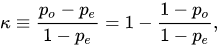
where po is the relative observed agreement among raters (identical to accuracy), and pe is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category. If the raters are in complete agreement then kappa =1. If there is no agreement among the raters other than what would be expected by chance (as given by pe), kappa =0.

Weighted Kappa is a small variation to this, here if two raters disagree with each other then the score is given according to the distance of the ratings given by both raters.That means that our score will be higher if (a) the real value is 4 but the model predicts a as 3, and the score will be lower if (b) the model instead predicts a as 0.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import cv2
#from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

#### 1. Exploratory Data Analysis and Feature Engineering

In [2]:
#fixing rnadom seed
np.random.seed(2019)
tf.set_random_seed(2019)
seed = 2019
IMG_SIZE=224

In [3]:
print(os.listdir('D:/Blindness Detection//2015_data'))

['resized test 15.zip', 'resized train 15.zip', 'testLabels15.csv', 'test_images', 'trainLabels15.csv', 'train_images', 'train_images_preprocessed', 'train_images_preprocessed[1, 0, 0, 0, 0]', 'train_images_preprocessed[1, 1, 0, 0, 0]', 'train_images_preprocessed[1, 1, 1, 0, 0]', 'train_images_preprocessed[1, 1, 1, 1, 0]', 'train_images_preprocessed[1, 1, 1, 1, 1]', 'train_images_preprocessed_backup']


#### 1.1 Loding Data

Note that we are loading a csv which has filename in column 'id_code' and the corresponding diagnosis given by doctor in column 'diagnosis'.

In [4]:
df_train = pd.read_csv('D:/Blindness Detection//train.csv')
df_test = pd.read_csv('D:/Blindness Detection//test.csv')

df_train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

#### 1.2 Splitting the train data into train and validation sets.

In [5]:
id_code = df_train['id_code']
diagnosis = df_train['diagnosis']

id_code, diagnosis = shuffle(id_code, diagnosis, random_state=seed)

train_x, valid_x, train_y, valid_y = train_test_split(id_code, diagnosis, test_size=0.15, stratify=diagnosis, random_state=seed)

train_x = train_x.reset_index(drop=True)
valid_x = valid_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
valid_y = valid_y.reset_index(drop=True)


print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(df_test.shape)

(3112,)
(3112,)
(550,)
(550,)
(1928, 1)


#### 1.3 Plotting the distribution of files which belong to different classes

In [6]:
#AppliedAIcourse.com
def plot_distribution(df, labels, t_cv_te='train'):
    '''
    This function prints the distribution of output variable in a given dataframe and also prints the stats
    '''
    print('-'*80)
    class_distribution = labels.value_counts().sort_index()
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi in ' + t_cv_te + ' data')
    plt.grid()
    plt.show()

    # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    # -(class_distribution.values): the minus sign will give us in decreasing order
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/labels.shape[0]*100), 3), '%)')


--------------------------------------------------------------------------------


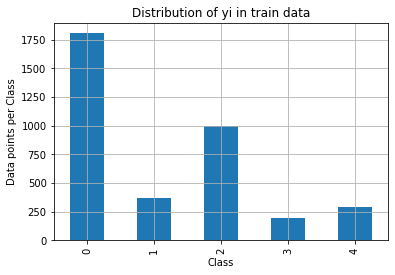

Number of data points in class 1 : 1805 ( 49.29 %)
Number of data points in class 3 : 999 ( 27.28 %)
Number of data points in class 2 : 370 ( 10.104 %)
Number of data points in class 5 : 295 ( 8.056 %)
Number of data points in class 4 : 193 ( 5.27 %)
--------------------------------------------------------------------------------


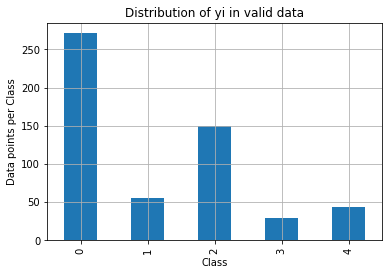

Number of data points in class 1 : 271 ( 49.273 %)
Number of data points in class 3 : 150 ( 27.273 %)
Number of data points in class 2 : 56 ( 10.182 %)
Number of data points in class 5 : 44 ( 8.0 %)
Number of data points in class 4 : 29 ( 5.273 %)


In [7]:
plot_distribution(df=df_train, labels=df_train['diagnosis'], t_cv_te='train')
plot_distribution(df=valid_x, labels=valid_y, t_cv_te='valid')

#### From the above distributions we can see that the classes 0 and 2 are dominant classes which means the data is imbalanced. Train and validation sets have similar percentage of images in each class.

#### 1.3 Image Preprocessing

#### 1.3.1 Image Features Enhancement

#### How do we know that a patient have diabetic retinopahy? There are at least 5 things to spot on. Image credit https://www.eyeops.com/
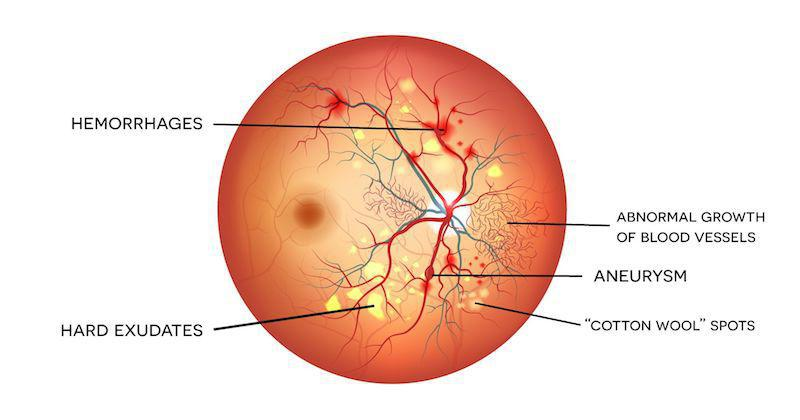

In [8]:
def image_preprocessing_1(df,labels,ben=False,sub_dir='train_images',sigmaX=10, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image to 256,256 shape and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    fig = plt.figure(figsize=(25,16))

    for class_id in sorted(labels.unique()):
        for i, (idx, row) in enumerate(df.loc[df['diagnosis']==class_id].sample(5,random_state=seed).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path="D:/Blindness Detection/"+sub_dir+'/'+row['id_code']+ext
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            if ben == True:
                #if the kernal size is [0,0] in gaussian blur then sigmaX is used for deciding the kernel size
                # https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/
                
                image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),sigmaX),-4,128)
            plt.imshow(image)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

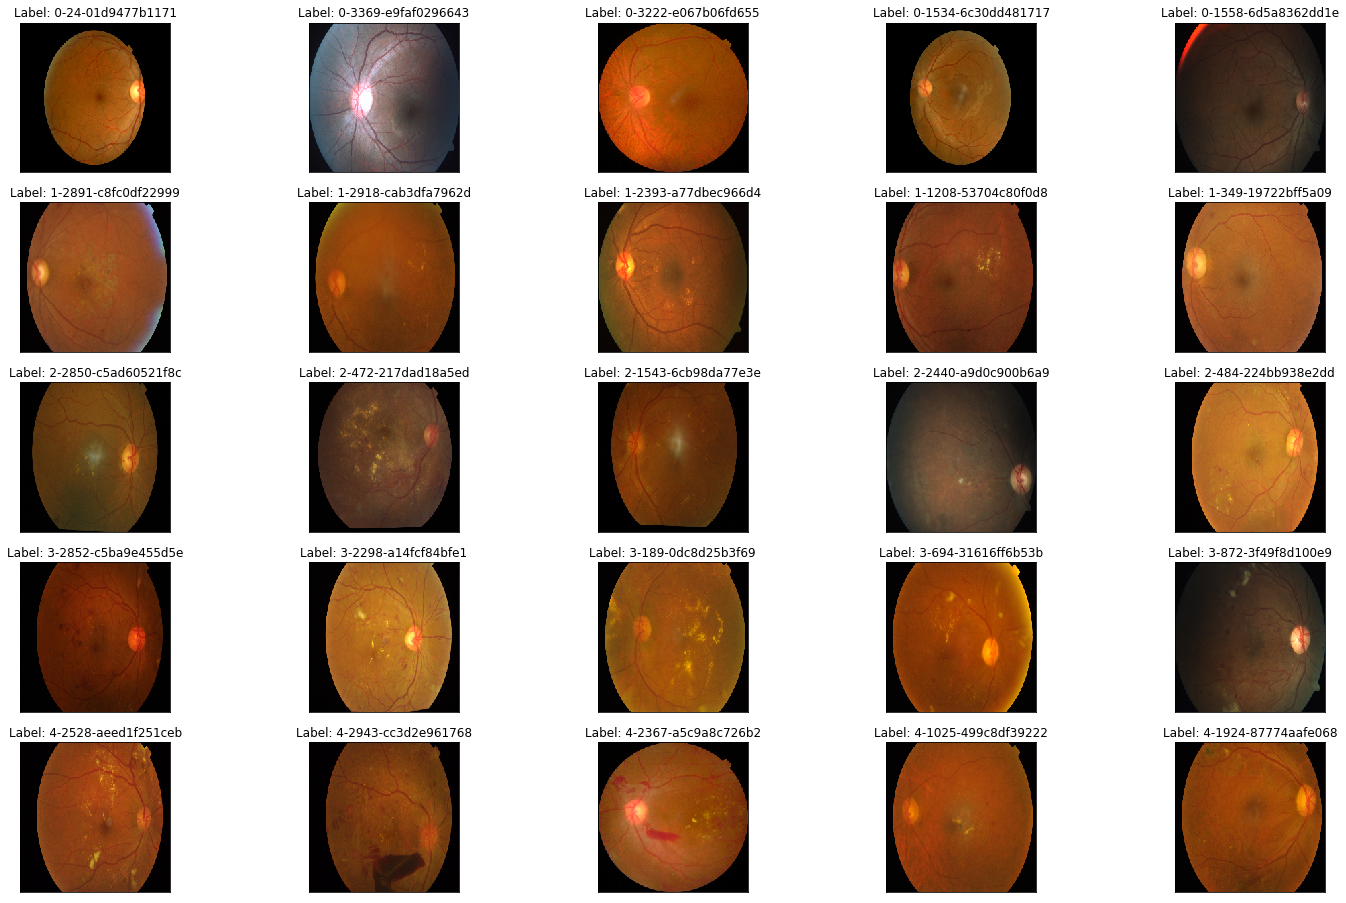

In [20]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=False,sub_dir = 'train_images')

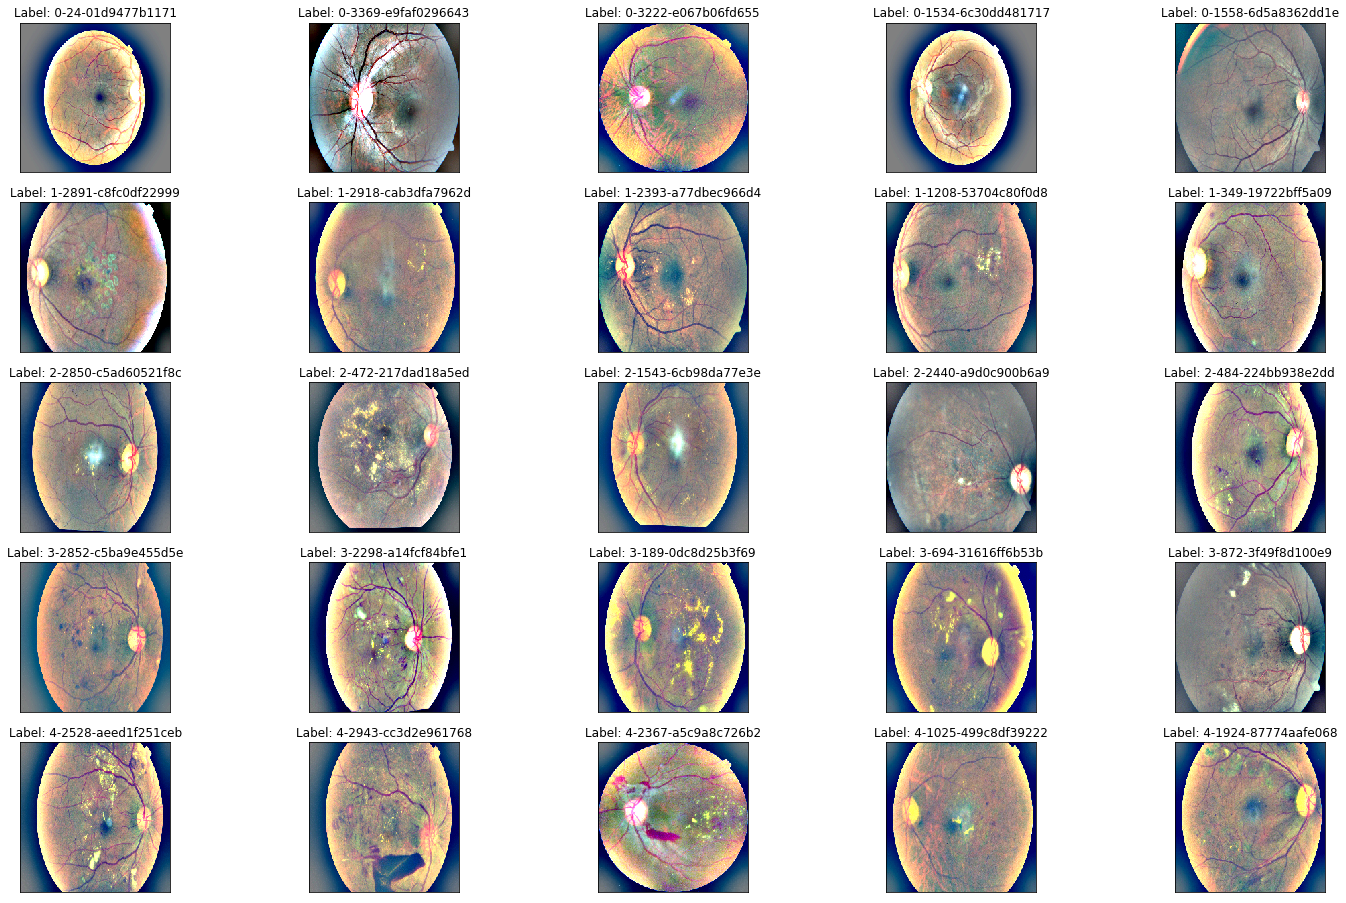

In [15]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=True,sub_dir = 'train_images',sigmaX=20)

#### From the above grids it is clear that the preprocessing has worked as the nerve,blood vessel features are visually more enhanced 

#### 1.3.2 Cropping dark edges from images

In [9]:
#https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934
def crop_dark_extras(img,tol=7):
    '''
    This function is used to crop out the additions dark areas in the images as this information is not useful
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    

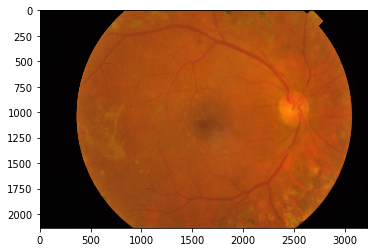

In [17]:
img = cv2.imread("D:/Blindness Detection/"+'train_images'+'/'+ df_train['id_code'][1] +'.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

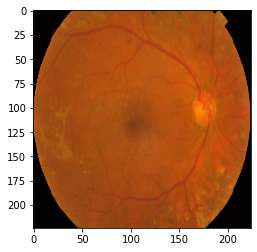

In [18]:
img = crop_dark_extras(img=img,tol=7)
img = cv2.resize(img, (224,224))
plt.imshow(img)

#### In the following cells the each image will be read from hard-disk, enchanced and also cropped, the resulting image is converted into an array representation and stored on disk 

In [8]:
def Preprocessing_images(df, sub_dir, ben=False, sigmaX=10, img_size=224, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    rows = df.shape[0]
    df_as_nd_array = np.empty((rows,img_size,img_size,3),dtype=np.uint8)

    for i,id_code in enumerate(tqdm(df)):
        path = "D:/Blindness Detection/"+sub_dir+'/'+ id_code + ext
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_dark_extras(img=img,tol=7)
        img = cv2.resize(img, (img_size,img_size))
        if ben == True:
            #if the kernal size is [0,0] in gaussian blur then sigmaX is used for deciding the kernel size
            # https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/
            img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),sigmaX),-4,128)
        df_as_nd_array[i,:,:,:] = img
        
    return df_as_nd_array

In [6]:
if os.path.exists('D:/Blindness Detection/x_train_224_2019.npy'):
    x_train = np.load("D:/Blindness Detection/x_train_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_train = Preprocessing_images(df=train_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_train_224_2019', arr=x_train)
                 
if os.path.exists('D:/Blindness Detection/x_valid_224_2019.npy'):
    x_valid = np.load("D:/Blindness Detection/x_valid_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_valid = Preprocessing_images(df=valid_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_valid_224_2019', arr=x_valid)

print(x_train.shape)
print(x_valid.shape)

(3112, 224, 224, 3)
(550, 224, 224, 3)


In [7]:
if os.path.exists('D:/Blindness Detection/x_test_224_2019.npy'):
    x_test = np.load("D:/Blindness Detection/x_test_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_test = Preprocessing_images(df=df_test['id_code'], sub_dir='test_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_test_224_2019', arr=x_test)

print(x_test.shape)

(1928, 224, 224, 3)


#### 1.4 Transforming Output variables.

The given output variables are categorical and this means the problem is posed as a categorical classification problem with reference to the following paper #https://arxiv.org/pdf/0704.1028.pdf it is better to trasnform such problems into ordinal regression problems.

In [8]:
#below code converts categorical outputs into onhot encoded like vectors
y_train = pd.get_dummies(train_y).values
y_valid = pd.get_dummies(valid_y).values

print(y_train.shape)
print(y_valid.shape)

(3112, 5)
(550, 5)


In [9]:
#https://arxiv.org/pdf/0704.1028.pdf
#https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets
def ordinal_regression(y):
    '''
    This function takes in the categorical(one hot encoded like) output varaible as input example [0,0,0,1,0] the output will be\
    [1,1,1,1,0] i.e all the categories before actual category are set to one
    '''
    y_multi = np.empty(y.shape, dtype=y.dtype)
    y_multi[:,4] = y[:,4] 

    for i in range(3,-1,-1):
        y_multi[:,i] = np.logical_or(y[:,i],y_multi[:,i+1])

    print(y_multi.shape)
    return y_multi

In [10]:
y_train=ordinal_regression(y_train)
y_valid=ordinal_regression(y_valid)

(3112, 5)
(550, 5)


In [11]:
#appliedaicouese.com
def plot_confusion_matrix(test_y, predict_y):
    '''
    Utility function to plot confuion matirx/ classification report, precision and recall matrices
    '''
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 5,5 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

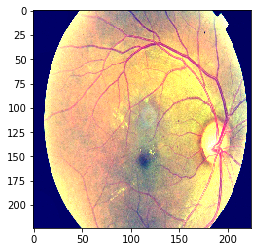

In [17]:
plt.imshow(x_train[1].reshape(IMG_SIZE,IMG_SIZE,3))

#### 2. Modelling

In [12]:
import numpy as np
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import Metric
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/CohenKappa
class CohenKappa(Metric):
    """Computes Kappa score between two raters.
    The score lies in the range [-1, 1]. A score of -1 represents
    complete disagreement between two raters whereas a score of 1
    represents complete agreement between the two raters.
    A score of 0 means agreement by chance.
    Note: As of now, this implementation considers all labels
    while calculating the Cohen's Kappa score.
    Usage:
    ```python
    actuals = np.array([4, 4, 3, 4, 2, 4, 1, 1], dtype=np.int32)
    preds = np.array([4, 4, 3, 4, 4, 2, 1, 1], dtype=np.int32)
    weights = np.array([1, 1, 2, 5, 10, 2, 3, 3], dtype=np.int32)
    m = tfa.metrics.CohenKappa(num_classes=5)
    m.update_state(actuals, preds)
    print('Final result: ', m.result().numpy()) # Result: 0.61904764
    # To use this with weights, sample_weight argument can be used.
    m = tfa.metrics.CohenKappa(num_classes=5)
    m.update_state(actuals, preds, sample_weight=weights)
    print('Final result: ', m.result().numpy()) # Result: 0.37209308
    ```
    Usage with tf.keras API:
    ```python
    model = tf.keras.models.Model(inputs, outputs)
    model.add_metric(tfa.metrics.CohenKappa(num_classes=5)(outputs))
    model.compile('sgd', loss='mse')
    ```
    """

    def __init__(self,
                 num_classes,
                 name='cohen_kappa',
                 weightage=None,
                 dtype=None):
        """Creates a `CohenKappa` instance.
        Args:
          num_classes: Number of unique classes in your dataset.
          name: (Optional) String name of the metric instance.
          weightage: (Optional) Weighting to be considered for calculating
            kappa statistics. A valid value is one of
            [None, 'linear', 'quadratic']. Defaults to `None`.
          dtype: (Optional) Data type of the metric result.
            Defaults to `None`.
        Raises:
          ValueError: If the value passed for `weightage` is invalid
            i.e. not any one of [None, 'linear', 'quadratic']
        """
        super(CohenKappa, self).__init__(name=name, dtype=tf.int64)


        self.weightage = weightage
        self.num_classes = num_classes


    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix condition statistics.
        Args:
          y_true: Labels assigned by the first annotator with shape
            `[num_samples,]`.
          y_pred: Labels assigned by the second annotator with shape
            `[num_samples,]`. The kappa statistic is symmetric,
            so swapping `y_true` and `y_pred` doesn't change the value.
          sample_weight (optional): for weighting labels in confusion matrix
            Defaults to `None`. The dtype for weights should be the same
            as the dtype for confusion matrix. For more details,
            please check `tf.math.confusion_matrix`.
        Returns:
          Update op.
        """
        y_true = tf.cast(y_true, dtype=tf.int64)
        y_pred = tf.cast(y_pred, dtype=tf.int64)

        #if y_true.shape != y_pred.shape:
        #    raise ValueError(
        #        "Number of samples in `y_true` and `y_pred` are different")

        # compute the new values of the confusion matrix
        new_conf_mtx = tf.math.confusion_matrix(
            labels=y_true,
            predictions=y_pred,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.int64)

        # update the values in the original confusion matrix
        return new_conf_mtx
    
    def result(self,conf_mtx):
        nb_ratings = tf.shape(conf_mtx)[0]
        weight_mtx = self.weightage
        # 2. Create a weight matrix
        weight_mtx += tf.cast(tf.range(nb_ratings), dtype=tf.int64)
        weight_mtx = tf.cast(weight_mtx, dtype=tf.int64)

        weight_mtx = tf.pow((weight_mtx - tf.transpose(weight_mtx)), 2)

        weight_mtx = tf.cast(weight_mtx, dtype=tf.int64)

        # 3. Get counts
        actual_ratings_hist = tf.reduce_sum(conf_mtx, axis=1)
        pred_ratings_hist = tf.reduce_sum(conf_mtx, axis=0)

        # 4. Get the outer product
        out_prod = pred_ratings_hist[..., None] * \
                    actual_ratings_hist[None, ...]

        # 5. Normalize the confusion matrix and outer product
        conf_mtx = conf_mtx / tf.reduce_sum(conf_mtx)
        out_prod = out_prod / tf.reduce_sum(pred_ratings_hist)
        
        conf_mtx = tf.cast(conf_mtx, dtype=tf.int64)
        out_prod = tf.cast(out_prod, dtype=tf.int64)

        # 6. Calculate Kappa score
        numerator = tf.reduce_sum(conf_mtx * weight_mtx)
        denominator = tf.reduce_sum(out_prod * weight_mtx)
        return 1 - (numerator / denominator)

In [13]:
#method-2 sklearn's method
def cohen_kappa_score_cus(y1, y2, labels=None, weights="quadratic", sample_weight=None):
    confusion = confusion_matrix(y1, y2, labels=labels,
                                 sample_weight=sample_weight)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return 1 - k

In [14]:
'''
Custom metric function defined to get cohen kappa score 
'''
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint

def kappa(y_true, y_pred):
        
        y_actual = tf.cast(tf.math.reduce_sum(y_true,axis=1)- 1,dtype=tf.int64)
        y_pred = tf.cast(y_pred,dtype=tf.float32)
        limit = tf.constant([0.5],dtype=tf.float32)
    
        y_pred_reversed = tf.reverse(tf.math.greater(y_pred,limit),axis=[1])
        y_pred_reversed = tf.cast(y_pred_reversed,tf.int64)
    
        indices = tf.math.argmax(y_pred_reversed,axis=1)
        y_pred_ordinal = 4-indices
        y_pred_ordinal = tf.cast(y_pred_ordinal,tf.int64)
        
        weight_mtx = tf.zeros([5, 5], dtype=tf.int64)
        
        #method-1 claculating using customized tfa.cohen_kappa_score function
        kappa = CohenKappa(num_classes=5,weightage=weight_mtx)
        conf_mtx = kappa.update_state(y_actual,y_pred_ordinal)
        val_kappa = kappa.result(conf_mtx)
        
        #method-2 calculating using sklearn's kappa socre function
        #val_kappa = tf.py_func(cohen_kappa_score_cus,[y_actual,y_pred_ordinal],tf.double)
        
        return val_kappa

Using TensorFlow backend.


#### 2.1 Models with self built architectures

#### 2.1.1 Baseline Model with simple architecture:

In [15]:
import keras as keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Reshape, Permute, Activation
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard , EarlyStopping
import time

In [44]:
Name = "Model_baseline_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

model_base = Sequential()
model_base.add(Conv2D(16, kernel_size=(3, 3),padding='same',
                 activation='relu',
                 input_shape=(IMG_SIZE,IMG_SIZE,3)))

model_base.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))
model_base.add(Dropout(0.3))


model_base.add(Flatten())

model_base.add(BatchNormalization())

model_base.add(Dense(5, activation='sigmoid'))

model_base.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="new_kappa_weights/weights_baseline.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint] + [tensorboard]

model_base.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 401408)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 401408)            1605632   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [22]:
history=model_base.fit(x_train, y_train,
          batch_size=16,
          epochs=10,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=1)

Train on 3112 samples, validate on 550 samples
Epoch 1/10
3112/3112 [==============================] - 46s 15ms/step - loss: 1.7351 - kappa: 0.5330 - val_loss: 1.4125 - val_kappa: 0.6800

Epoch 00001: val_kappa improved from -inf to 0.68002, saving model to new_kappa_weights/weights_baseline.best.hdf5
Epoch 2/10
3112/3112 [==============================] - 53s 17ms/step - loss: 1.4381 - kappa: 0.6784 - val_loss: 1.3946 - val_kappa: 0.6873

Epoch 00002: val_kappa improved from 0.68002 to 0.68733, saving model to new_kappa_weights/weights_baseline.best.hdf5
Epoch 3/10
3112/3112 [==============================] - 55s 18ms/step - loss: 1.4098 - kappa: 0.6886 - val_loss: 5.0933 - val_kappa: 0.0418

Epoch 00003: val_kappa did not improve from 0.68733
Epoch 4/10
3112/3112 [==============================] - 51s 16ms/step - loss: 1.4122 - kappa: 0.6975 - val_loss: 1.3861 - val_kappa: 0.6827

Epoch 00004: val_kappa did not improve from 0.68733
Epoch 5/10
3112/3112 [==============================

In [ ]:
model_base.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_base.h5')

In [ ]:
from keras.models import load_model

#model = load_model('new_kappa_models/model_base.h5')

In [23]:
model_base.load_weights(filepath)
score = model_base.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score[0])
print('Test kappa:', score[1])


Test loss: 1.3423700989376415
Test kappa: 0.7012878907618247


In [24]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_base.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  30.363636363636363
-------------------------------------------------- Confusion matrix --------------------------------------------------


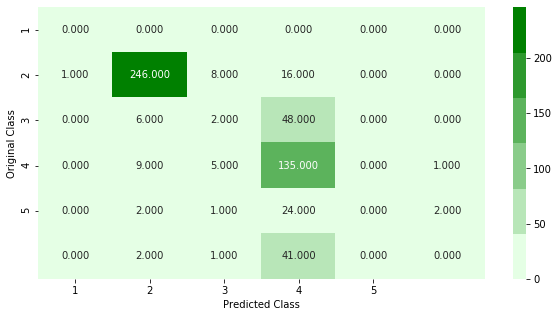

-------------------------------------------------- Precision matrix --------------------------------------------------


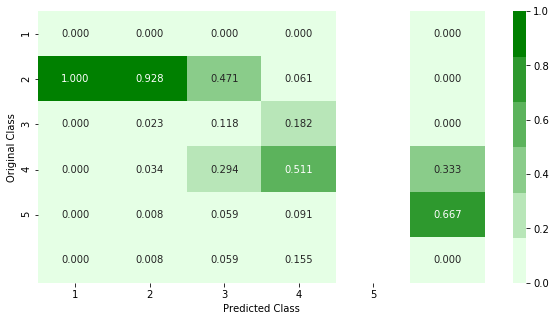

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


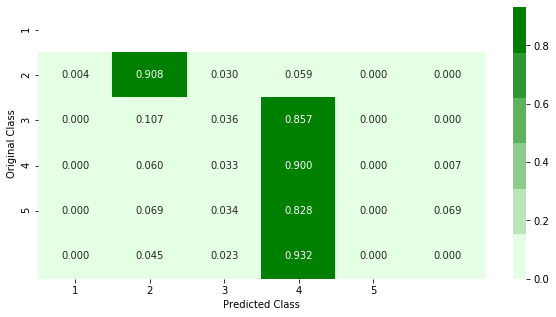

Sum of rows in precision matrix [nan  1.  1.  1.  1.  1.]


In [25]:
plot_confusion_matrix(actual_y, y_pred)

#### From the above matrices we can clearly see that the classes 1 and 3 are dominating in numbers and most of the points which belong to class 2,4,5 are mis classified to belong to calss 3

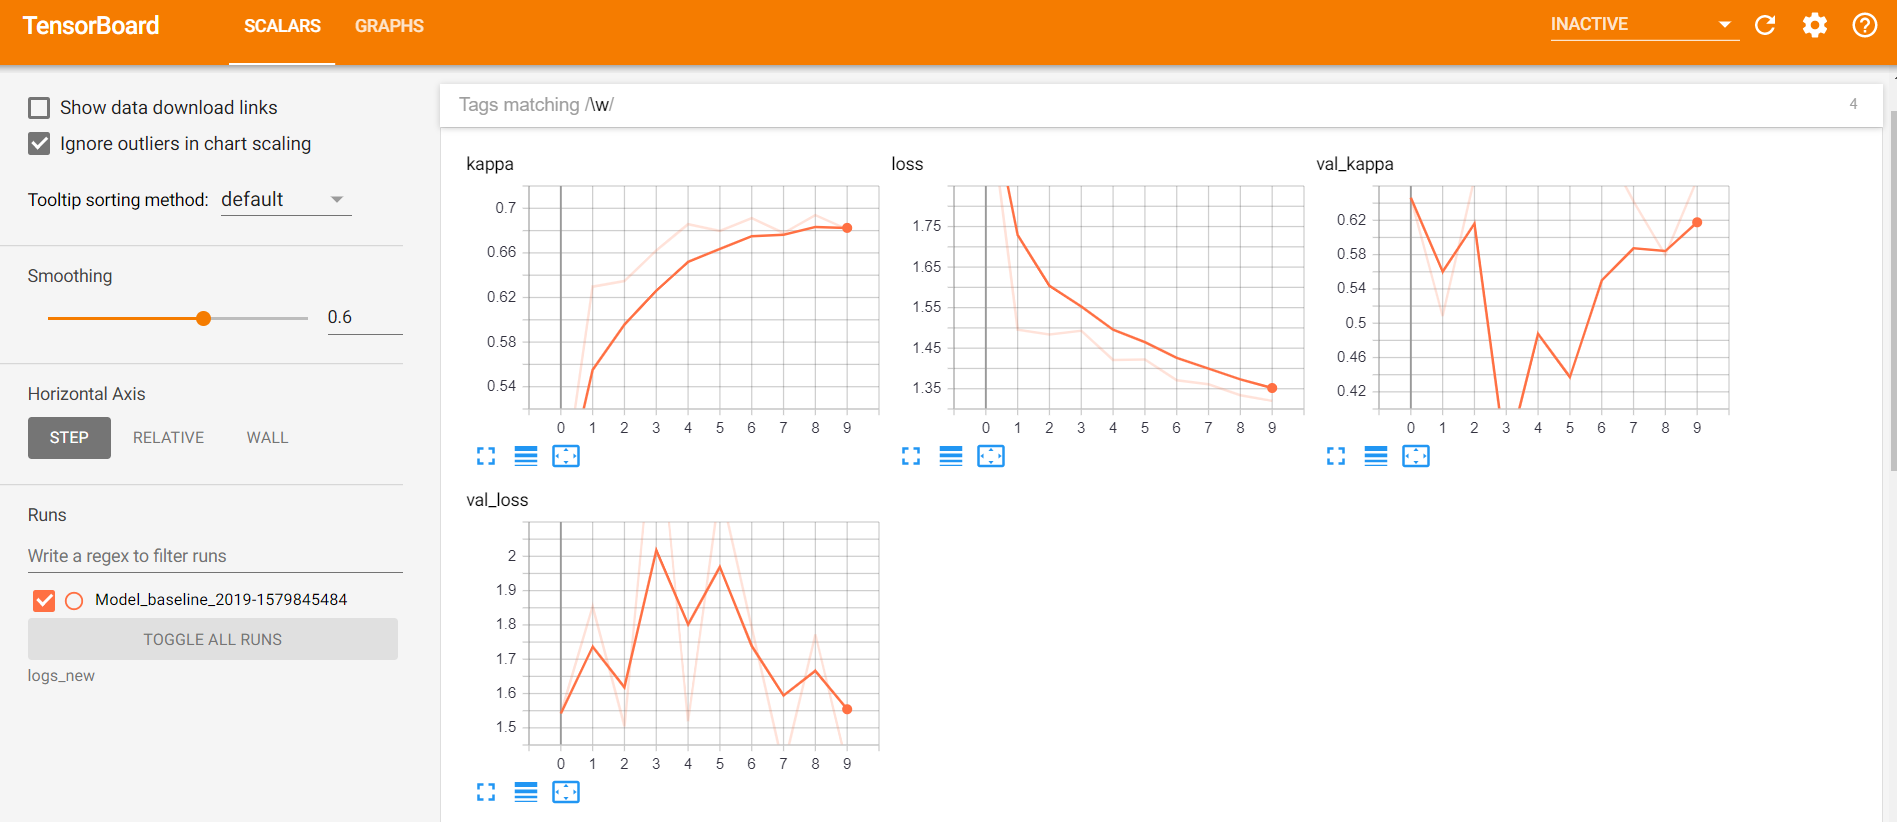

#### 2.1.2 Trying out with a deeper and wider model to see if there are any improvements.

In [28]:
Name = "Model_second_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

model_two = Sequential()
model_two.add(Conv2D(filters=16, kernel_size=3,\
                         padding='same',\
                         activation='relu', \
                         kernel_initializer = 'he_normal',\
                         input_shape=(224,224,3)))
        
model_two.add(MaxPooling2D(pool_size=2))
        
model_two.add(Conv2D(filters=32, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(Conv2D(filters=64, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(BatchNormalization())
                  
model_two.add(MaxPooling2D(pool_size=2))

model_two.add(Dropout(0.5))
        
model_two.add(Flatten())

model_two.add(Dense(64, kernel_initializer = 'he_normal', activation='relu'))
        
model_two.add(BatchNormalization())
        
model_two.add(Dropout(0.5))

model_two.add(Dense(5, activation='sigmoid'))

model_two.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="new_kappa_weights/weights_two.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_two.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 32)      12832     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 56, 56, 64)       

In [29]:
history_two =model_two.fit(x_train, y_train,
          batch_size=16,
          epochs=30,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=2)

Train on 3112 samples, validate on 550 samples
Epoch 1/30
 - 28s - loss: 0.5612 - kappa: 0.1276 - val_loss: 0.3344 - val_kappa: 0.6812

Epoch 00001: val_kappa improved from -inf to 0.68122, saving model to new_kappa_weights/weights_two.hdf5
Epoch 2/30
 - 27s - loss: 0.3662 - kappa: 0.4228 - val_loss: 0.3139 - val_kappa: 0.6753

Epoch 00002: val_kappa did not improve from 0.68122
Epoch 3/30
 - 27s - loss: 0.2901 - kappa: 0.6132 - val_loss: 1.0948 - val_kappa: 0.1471

Epoch 00003: val_kappa did not improve from 0.68122
Epoch 4/30
 - 27s - loss: 0.2677 - kappa: 0.6490 - val_loss: 0.2364 - val_kappa: 0.6829

Epoch 00004: val_kappa improved from 0.68122 to 0.68285, saving model to new_kappa_weights/weights_two.hdf5
Epoch 5/30
 - 27s - loss: 0.2512 - kappa: 0.6654 - val_loss: 0.2178 - val_kappa: 0.6905

Epoch 00005: val_kappa improved from 0.68285 to 0.69049, saving model to new_kappa_weights/weights_two.hdf5
Epoch 6/30
 - 27s - loss: 0.2357 - kappa: 0.6886 - val_loss: 0.2250 - val_kappa: 0.

In [30]:
model_two.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_two.h5')

In [31]:
from keras.models import load_model

#model_two = load_model('new_kappa_models/model_two.h5')

In [32]:
model_two.load_weights(filepath)
score_two = model_two.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_two[0])
print('Test accuracy:', score_two[1])

Test loss: 0.2084231315146793
Test accuracy: 0.8040187003395775


In [33]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_two.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1

Number of misclassified points  27.090909090909093
-------------------------------------------------- Confusion matrix --------------------------------------------------


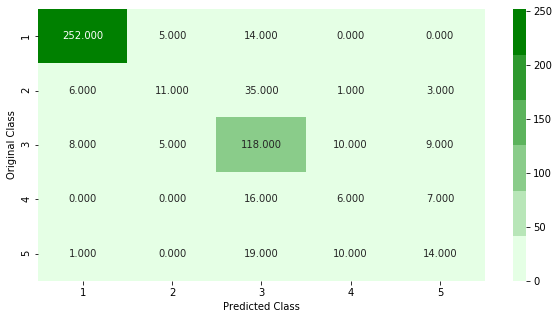

-------------------------------------------------- Precision matrix --------------------------------------------------


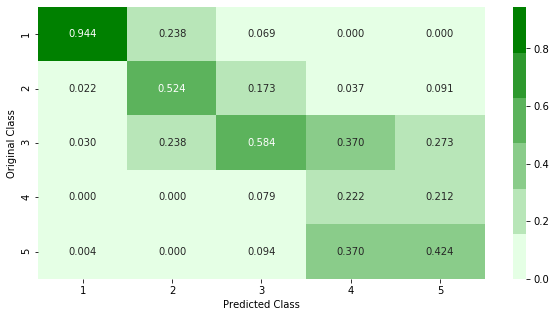

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


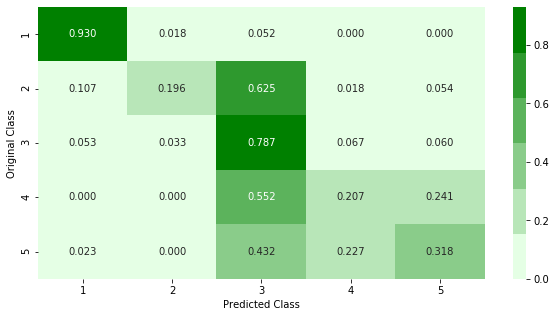

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [34]:
actual_y = y_valid.sum(axis=1) - 1 

plot_confusion_matrix(actual_y, y_pred)

#### From the above confusion matrices we can see that  model_two has improved from our baseline model performance on classes 4 and 5 has also improved to a certain extent yet the dominance of class 3 is still evident.

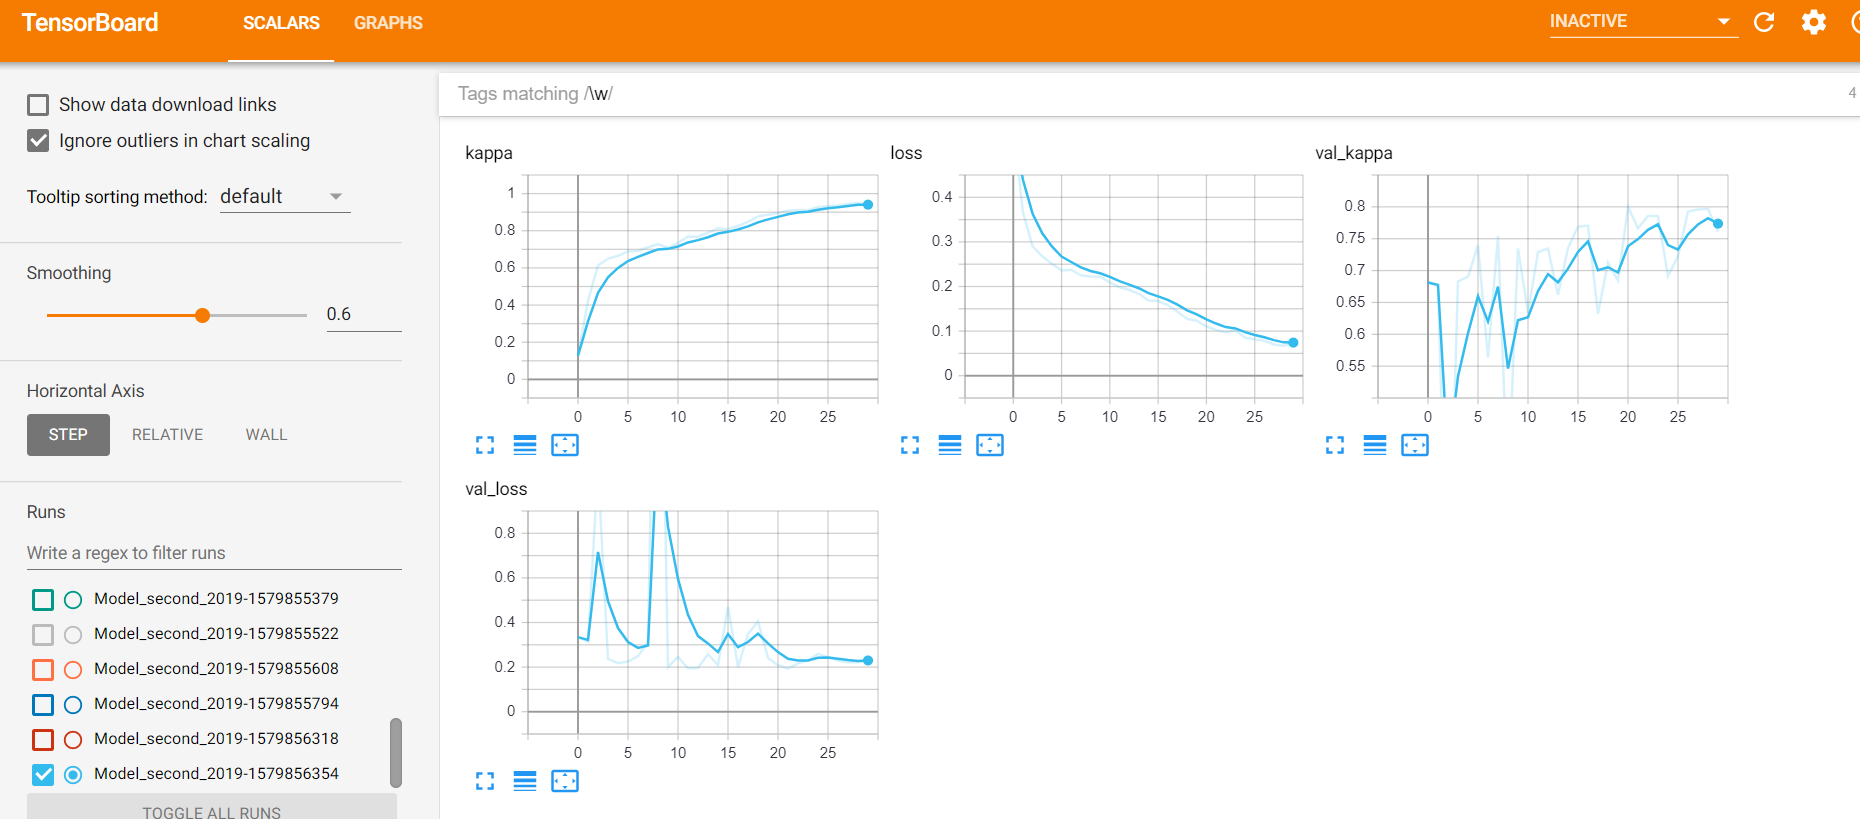

#### Multiple such architectures and parameters were experimented with using Hyperas the code for which is present at the end of this notebook.
After many hours of experimentation the highest kappa score attaind was around 0.80

####  2.2 Trying Transfer Learning Technique to see if they work on our data.

The idea here is that there are multiple state of the art architectures built on large image datasets which might also perform well on our dataset.

#### 2.2.1 Using Densent Architecture with weights attained from Imagenet dataset.

In [35]:
from keras.applications import DenseNet121

Name = "Model_third_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

densenet = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_three = Sequential()
model_three.add(densenet)
model_three.add(GlobalAveragePooling2D())
model_three.add(Dropout(0.5))
model_three.add(Dense(5, activation='sigmoid'))
    
model_three.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_three.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint] + [tensorboard] 

model_three.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


#### The number of parameters used in this architectures is approximately 7Million 

In [36]:
history_three =model_three.fit(x_train, y_train,
          batch_size=8,
          epochs=30,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=2)

Train on 3112 samples, validate on 550 samples
Epoch 1/30
 - 160s - loss: 0.3080 - kappa: 0.6188 - val_loss: 0.1638 - val_kappa: 0.8479

Epoch 00001: val_kappa improved from -inf to 0.84788, saving model to new_kappa_weights/weights_three.hdf5
Epoch 2/30
 - 136s - loss: 0.1746 - kappa: 0.8196 - val_loss: 0.1335 - val_kappa: 0.8570

Epoch 00002: val_kappa improved from 0.84788 to 0.85704, saving model to new_kappa_weights/weights_three.hdf5
Epoch 3/30
 - 137s - loss: 0.1321 - kappa: 0.8699 - val_loss: 0.1219 - val_kappa: 0.8799

Epoch 00003: val_kappa improved from 0.85704 to 0.87988, saving model to new_kappa_weights/weights_three.hdf5
Epoch 4/30
 - 137s - loss: 0.0959 - kappa: 0.9130 - val_loss: 0.1378 - val_kappa: 0.8793

Epoch 00004: val_kappa did not improve from 0.87988
Epoch 5/30
 - 137s - loss: 0.0861 - kappa: 0.9165 - val_loss: 0.1391 - val_kappa: 0.8536

Epoch 00005: val_kappa did not improve from 0.87988
Epoch 6/30
 - 137s - loss: 0.0660 - kappa: 0.9471 - val_loss: 0.1316 - v

In [37]:
model_three.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_three.h5')

#model = load_model('new_kappa_models/model_base.h5')

In [41]:
model_three.load_weights(filepath)
score_three = model_three.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_three[0])
print('Test kappa:', score_three[1])

Test loss: 0.14412418183277953
Test kappa: 0.9016966074163264


In [39]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_three.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  17.272727272727273
-------------------------------------------------- Confusion matrix --------------------------------------------------


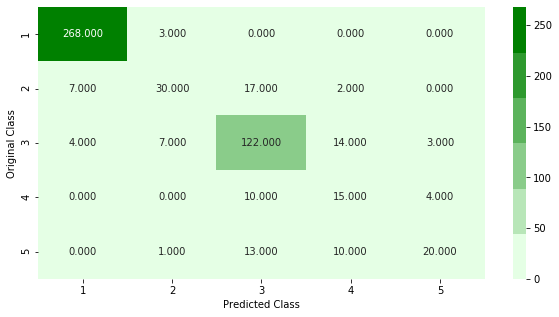

-------------------------------------------------- Precision matrix --------------------------------------------------


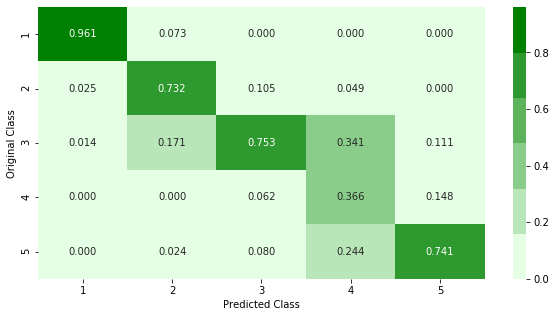

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


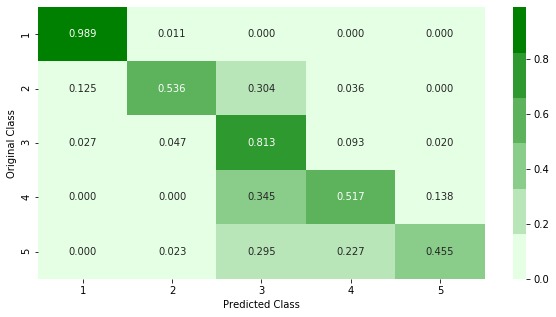

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [40]:
plot_confusion_matrix(actual_y, y_pred)

#### The performance bump in terms of Kappa score and accuracy is very high in model three, this is partially due to the architecture and also due to the size of the imagenet dataset using which we obtained the initial weights

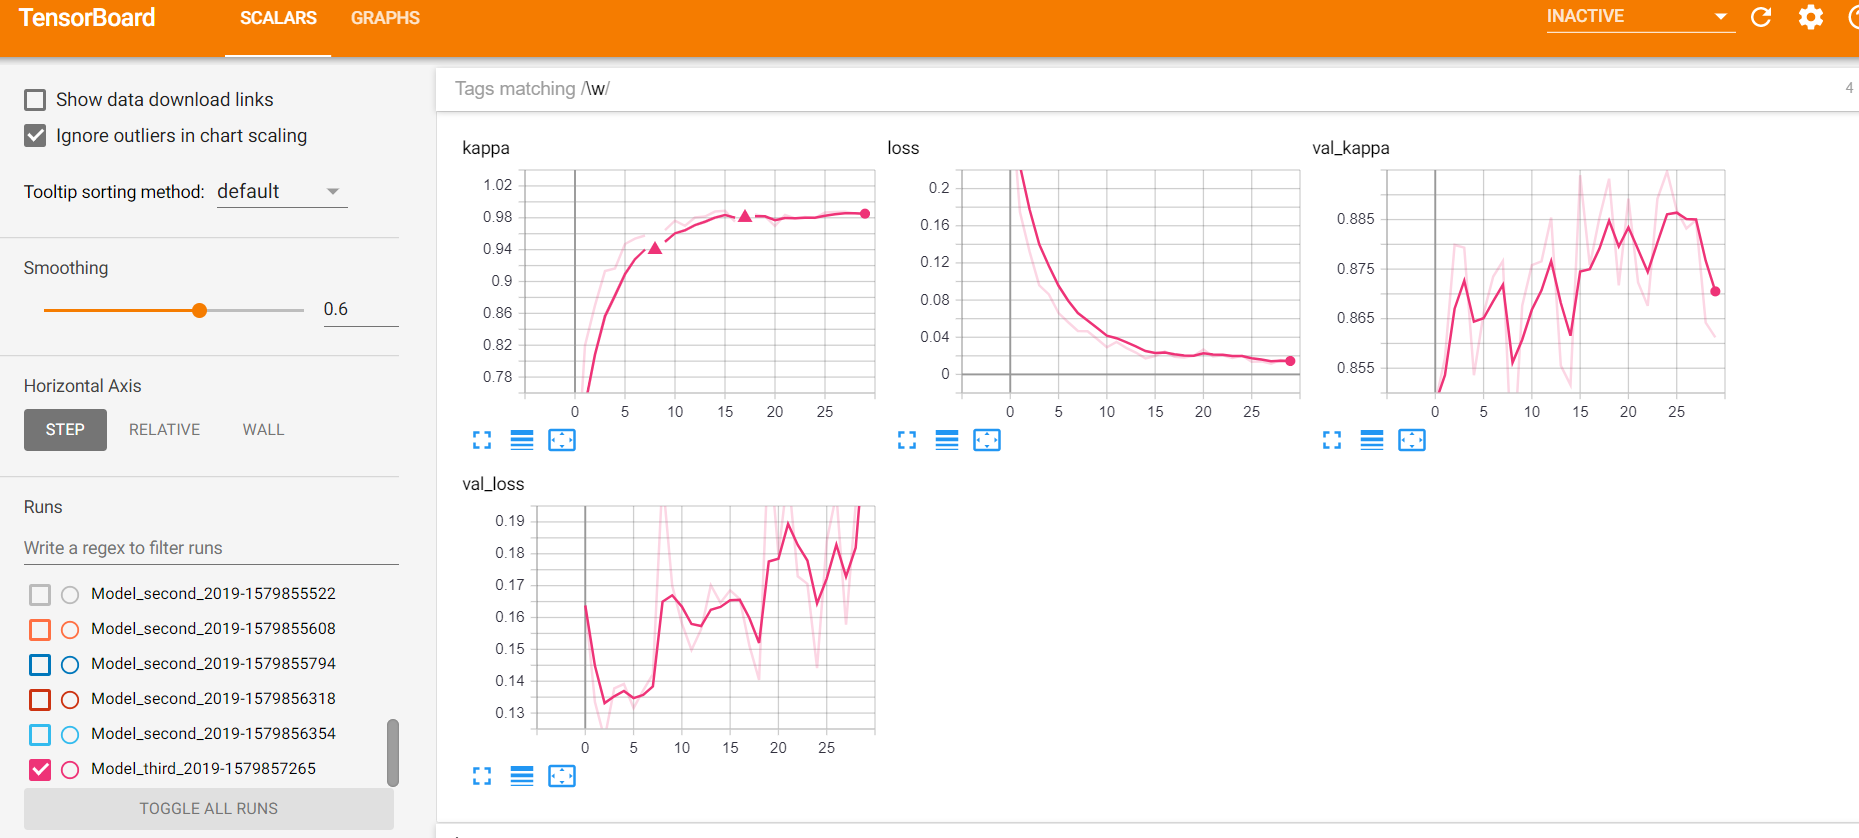

#### 2.3 Transfer Learning with Image Augmentation.

#### Data Augmentation Technique-Image Data Generator.

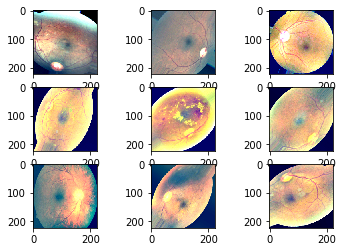

In [16]:
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_batch[i].astype('uint8'))
	# show the plot
	pyplot.show()
	break

In [18]:
from keras.applications import DenseNet121

Name = "Model_image_gen_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

densenet = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_four = Sequential()
model_four.add(densenet)
model_four.add(GlobalAveragePooling2D())
model_four.add(Dropout(0.5))
model_four.add(Dense(5, activation='sigmoid'))
    
model_four.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_image_gen.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_four.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
history_four =model_four.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)






Epoch 1/30
389/389 [==============================] - 238s 612ms/step - loss: 0.3210 - kappa: 0.5989 - val_loss: 0.1615 - val_kappa: 0.8480

Epoch 00001: val_kappa improved from -inf to 0.84801, saving model to new_kappa_weights/weights_image_gen.hdf5

Epoch 2/30
389/389 [==============================] - 154s 397ms/step - loss: 0.2007 - kappa: 0.7830 - val_loss: 0.1481 - val_kappa: 0.8362

Epoch 00002: val_kappa did not improve from 0.84801
Epoch 3/30
389/389 [==============================] - 154s 396ms/step - loss: 0.1728 - kappa: 0.8189 - val_loss: 0.1473 - val_kappa: 0.8344

Epoch 00003: val_kappa did not improve from 0.84801
Epoch 4/30
389/389 [==============================] - 154s 396ms/step - loss: 0.1497 - kappa: 0.8427 - val_loss: 0.1387 - val_kappa: 0.8395

Epoch 00004: val_kappa did not improve from 0.84801
Epoch 5/30
389/389 [==============================] - 154s 395ms/step - loss: 0.1483 - kappa: 0.8472 - val_loss: 0.1294 - val_kappa: 0.8678

Epoch 00005: val_kappa 

In [20]:
model_four.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_four.h5')
#model_four = load_model(filepath)

In [21]:
model_four.load_weights(filepath)
score_three = model_four.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_three[0])
print('Test kappa:', score_three[1])



y_pred = model_four.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Test loss: 0.10946821402419697
Test accuracy: 0.9286095469648188


Number of misclassified points  14.181818181818182
-------------------------------------------------- Confusion matrix --------------------------------------------------


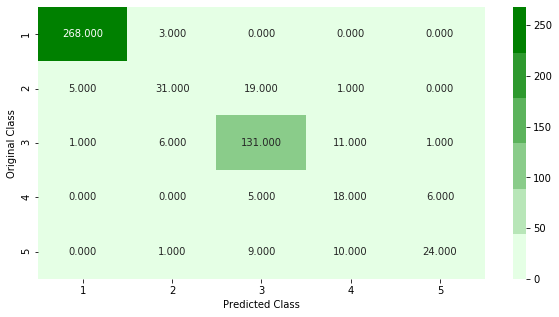

-------------------------------------------------- Precision matrix --------------------------------------------------


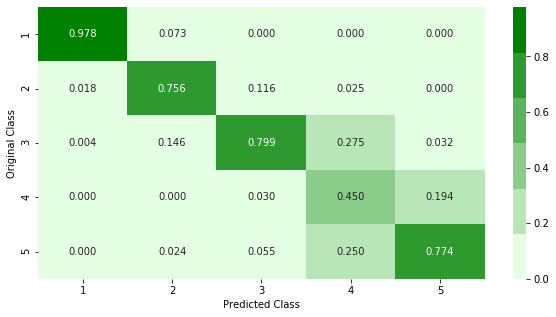

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


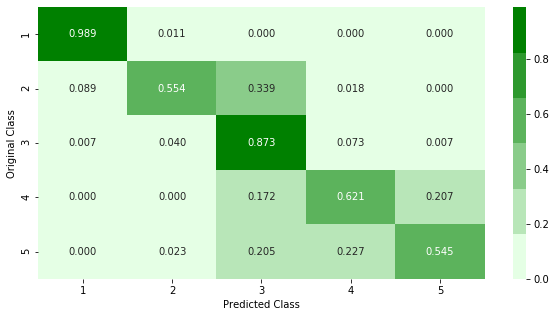

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [22]:
plot_confusion_matrix(actual_y, y_pred)

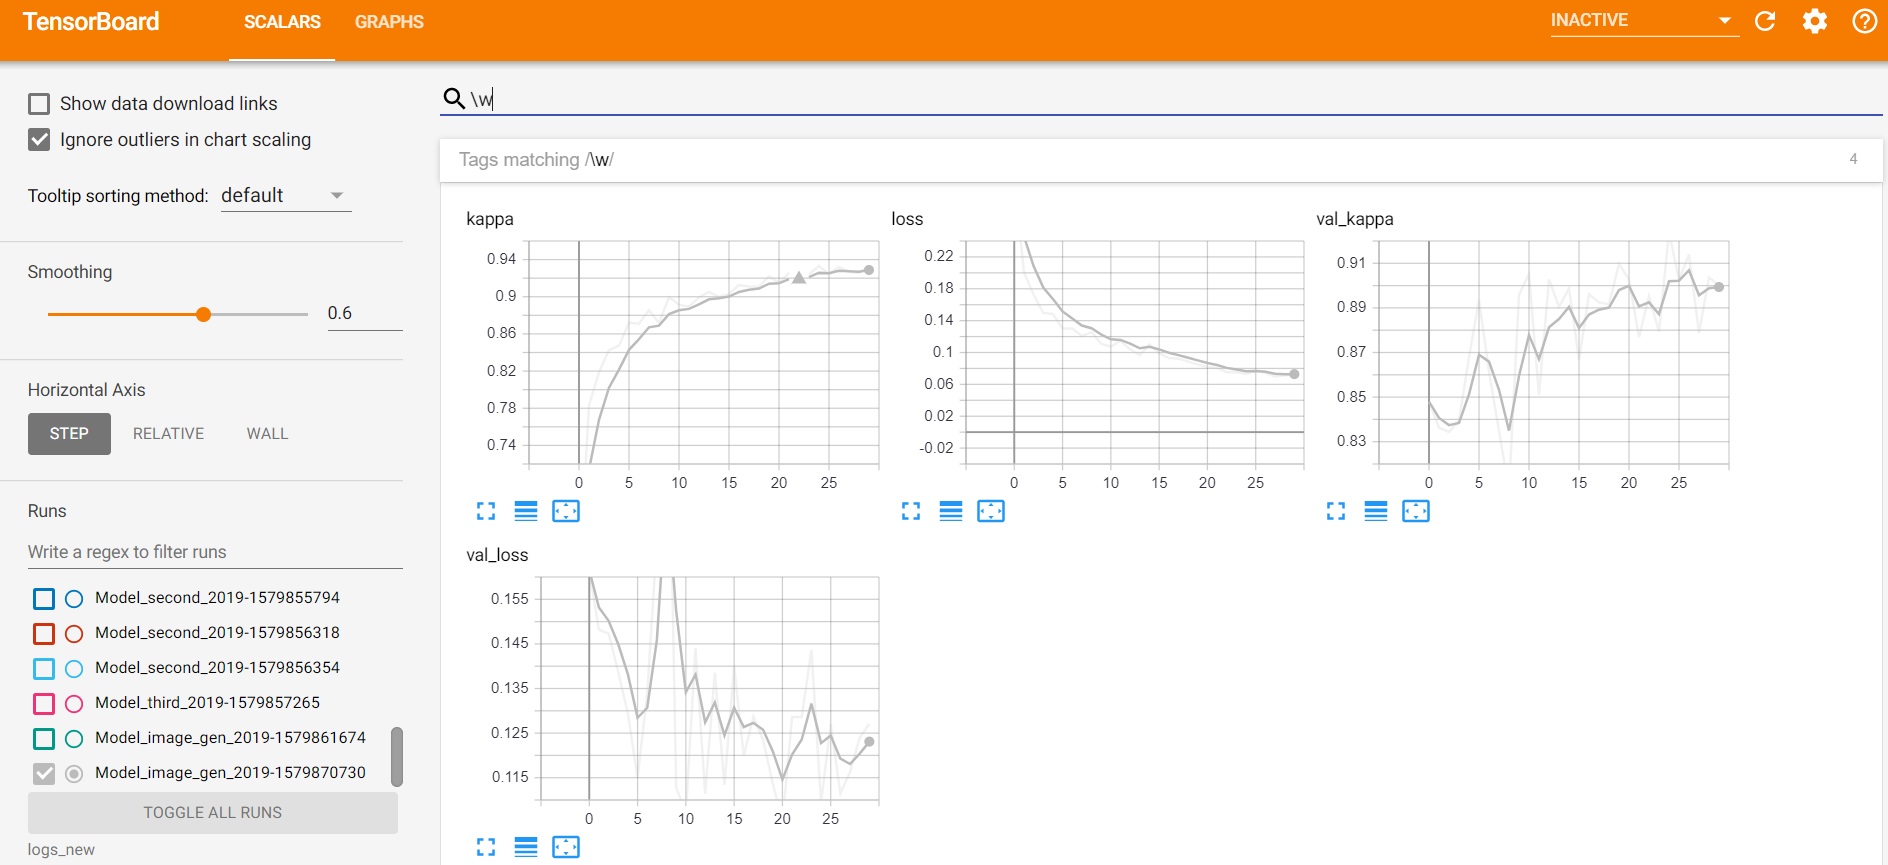

#### From the above plots we can see that the Model uisng Image data Genaretor performs better as it introduces variation in the inputs which is crucial in sitations where we have less data to train on. 

#### 2.4 Utilizing External Data.

#### A similar problem to our's was solved in an earlier kaggle competetion hosted in 2015, From which we can leverage the data to train our models on a larger dataset and possibly improve the performance.

The dataset is acquired from https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized
where the images are available in .jpeg format as opposed to .png format of the otiginal so as to reduce space consumption.

#### 2.4.1 Loading 2015  Data

In [9]:
print(os.listdir('D:/Blindness Detection//2015_data'))

['resized test 15.zip', 'resized train 15.zip', 'testLabels15.csv', 'test_images', 'trainLabels15.csv', 'train_images', 'train_images_preprocessed', 'train_images_preprocessed[1, 0, 0, 0, 0]', 'train_images_preprocessed[1, 1, 0, 0, 0]', 'train_images_preprocessed[1, 1, 1, 0, 0]', 'train_images_preprocessed[1, 1, 1, 1, 0]', 'train_images_preprocessed[1, 1, 1, 1, 1]', 'train_images_preprocessed_backup']


In [10]:
df_2015_train = pd.read_csv('D:/Blindness Detection/2015_data//trainLabels15.csv')
df_2015_test = pd.read_csv('D:/Blindness Detection/2015_data//testLabels15.csv')

df_2015_train.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [11]:
df_2015_train.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)
df_2015_test.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)

df_2015_train.head()

id_code  diagnosis
0   10_left          0
1  10_right          0
2   13_left          0
3  13_right          0
4   15_left          1

--------------------------------------------------------------------------------


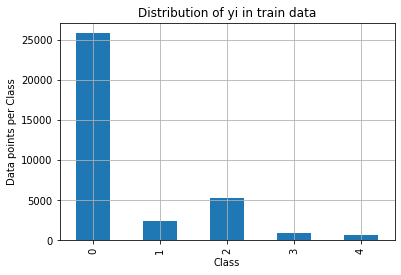

Number of data points in class 1 : 25810 ( 73.478 %)
Number of data points in class 3 : 5292 ( 15.066 %)
Number of data points in class 2 : 2443 ( 6.955 %)
Number of data points in class 4 : 873 ( 2.485 %)
Number of data points in class 5 : 708 ( 2.016 %)
--------------------------------------------------------------------------------


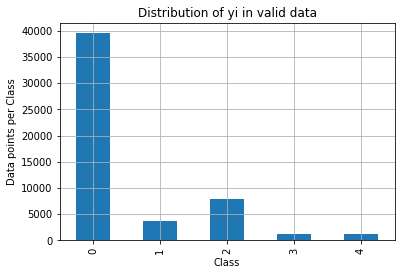

Number of data points in class 1 : 39533 ( 73.789 %)
Number of data points in class 3 : 7861 ( 14.673 %)
Number of data points in class 2 : 3762 ( 7.022 %)
Number of data points in class 4 : 1214 ( 2.266 %)
Number of data points in class 5 : 1206 ( 2.251 %)


In [12]:
plot_distribution(df=df_2015_train, labels=df_2015_train['diagnosis'], t_cv_te='train')
plot_distribution(df=df_2015_test, labels=df_2015_test['diagnosis'], t_cv_te='valid')

In [13]:
#Converting the output variable into ordinals

y_train = pd.get_dummies(df_2015_train['diagnosis']).values
y_test = pd.get_dummies(df_2015_test['diagnosis']).values

y_train=ordinal_regression(y_train)
y_test=ordinal_regression(y_test)

df_2015_train['diagnosis']  = y_train.tolist()
df_2015_test['diagnosis']  = y_test.tolist()

df_2015_train.head()

(35126, 5)
(53576, 5)


id_code        diagnosis
0   10_left  [1, 0, 0, 0, 0]
1  10_right  [1, 0, 0, 0, 0]
2   13_left  [1, 0, 0, 0, 0]
3  13_right  [1, 0, 0, 0, 0]
4   15_left  [1, 1, 0, 0, 0]

#### 2.4.2 Preprocessing 2015 Images

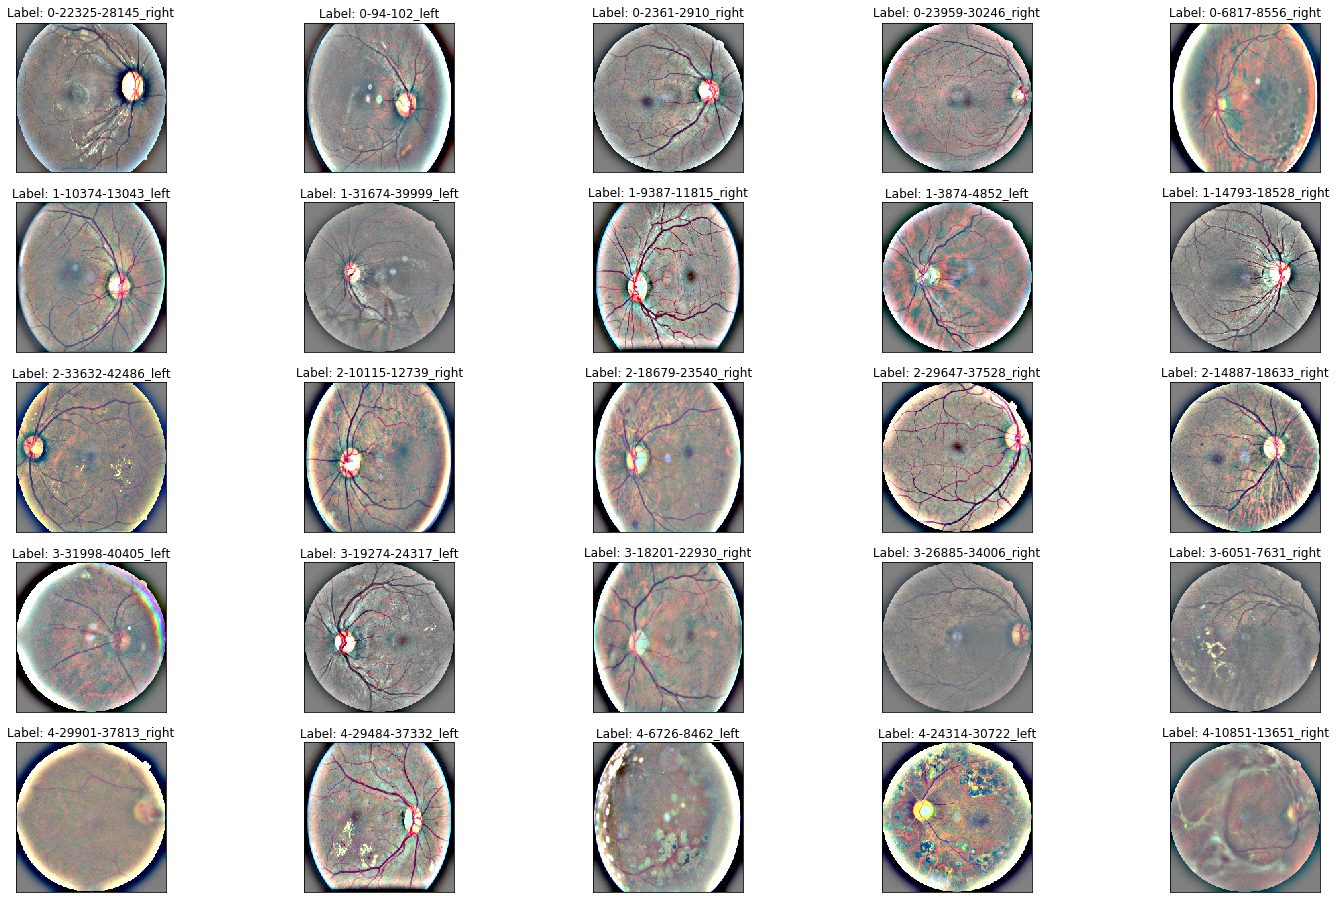

In [28]:
image_preprocessing_1(df_2015_train,df_2015_train['diagnosis'],ben=True,\
                      sub_dir = '2015_data/train_images',sigmaX=10, ext='.jpg')

#### From the above examples we can see that SigmaX=10 works best for this dataset.

#### Since the size of data is very large in this case(88702 images in total) we will run into memory issues if numpy arrays are used hence we shall preprocess all the images and store them on hard disk and read each image from hard disk during run time.

In [15]:
def Preprocessing_images_2015(df, sub_dir, ben=False, sigmaX=10, category = '[1,0,0,0,0]', img_size=224, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    for i,id_code in enumerate(tqdm(df)):
            path = "D:/Blindness Detection/2015_data/"+sub_dir+'/'+ id_code + ext
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = crop_dark_extras(img=img,tol=7)
            img = cv2.resize(img, (img_size,img_size))
            if ben == True:
                #if the kernal size is [0,0] in gaussian blur then sigmaX is used for deciding the kernel size
                # https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/
                img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),sigmaX),-4,128)

            save_path = "D:/Blindness Detection/2015_data/train_images_preprocessed/"+str(category)+'/'+ id_code + ext
            cv2.imwrite(save_path, img)  
            
    print("Processing Has ended") 

#### Note We will preprocess both train and test images and save all of them in a single folder essentially creating a large train data set for our model to learn from as the perforance of our model on 2015's test data is not important to us.

In [17]:
if not os.path.exists('D:/Blindness Detection/2015_data/train_images_preprocessed'):
    #preprocessing train images
    #create a subfolder for each class in dataset
    for category in np.unique(df_2015_train['diagnosis'].values):
        if not os.path.exists('D:/Blindness Detection/2015_data/train_images_preprocessed'+str(category)):
            new_dir = 'D:/Blindness Detection/2015_data/train_images_preprocessed'+str(category)
            print('creating a new directory-',new_dir)
            os.mkdir(new_dir)
            
            #Preprocessing train images
            df = df_2015_train.loc[df_2015_train['diagnosis'].apply(tuple)==tuple(category)]
            Preprocessing_images_2015(df=df['id_code'], sub_dir='train_images', category=category, ben=True,\
                                                sigmaX=10, img_size=IMG_SIZE, ext='.jpg')
            
            #Preprocessing test images
            df = df_2015_test.loc[df_2015_test['diagnosis'].apply(tuple)==tuple(category)]
            Preprocessing_images_2015(df=df['id_code'], sub_dir='test_images', category=category, ben=True,\
                                                sigmaX=10, img_size=IMG_SIZE, ext='.jpg')

creating a new directory- D:/Blindness Detection/2015_data/train_images_preprocessed[1, 0, 0, 0, 0]


100%|████████████████████████████████████████████████████████████████████████████| 25810/25810 [22:51<00:00, 18.82it/s]


Processing Has ended


100%|████████████████████████████████████████████████████████████████████████████| 39533/39533 [42:37<00:00, 15.46it/s]


Processing Has ended
creating a new directory- D:/Blindness Detection/2015_data/train_images_preprocessed[1, 1, 0, 0, 0]


100%|██████████████████████████████████████████████████████████████████████████████| 2443/2443 [01:57<00:00, 20.08it/s]


Processing Has ended


100%|██████████████████████████████████████████████████████████████████████████████| 3762/3762 [03:11<00:00, 19.64it/s]


Processing Has ended
creating a new directory- D:/Blindness Detection/2015_data/train_images_preprocessed[1, 1, 1, 0, 0]


100%|██████████████████████████████████████████████████████████████████████████████| 5292/5292 [04:13<00:00, 21.20it/s]


Processing Has ended


100%|██████████████████████████████████████████████████████████████████████████████| 7861/7861 [07:05<00:00, 18.46it/s]


Processing Has ended
creating a new directory- D:/Blindness Detection/2015_data/train_images_preprocessed[1, 1, 1, 1, 0]


100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [00:44<00:00, 19.69it/s]


Processing Has ended


100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [01:08<00:00, 17.71it/s]


Processing Has ended
creating a new directory- D:/Blindness Detection/2015_data/train_images_preprocessed[1, 1, 1, 1, 1]


100%|████████████████████████████████████████████████████████████████████████████████| 708/708 [00:36<00:00, 19.20it/s]


Processing Has ended


100%|██████████████████████████████████████████████████████████████████████████████| 1206/1206 [01:04<00:00, 18.76it/s]


Processing Has ended


#### Creating a train data generator which will read the preprocessed images from hard disk and perform image augmentation prior to fitting it to the model

In [11]:
#https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# define data preparation
datagen = ImageDataGenerator(rescale=1/255,horizontal_flip=True,vertical_flip=True,rotation_range=180)


train_generator = datagen.flow_from_directory(directory = 'D:/Blindness Detection/2015_data/train_images_preprocessed',
                                              target_size = (IMG_SIZE,IMG_SIZE),
                                              batch_size = 8,
                                              class_mode = "categorical",
                                              seed=2019)

#validation_generator = datagen.flow_from_directory(directory = 'D:/Blindness Detection/2015_data/train_images_preprocessed',
#                                              target_size = (IMG_SIZE,IMG_SIZE),
#                                              batch_size = 8,
#                                              class_mode = "categorical",
#                                              subset = 'validation',
#                                              seed=2019)

Found 88566 images belonging to 5 classes.


#### 2.4.3 Densenet121 on 2015's data.

In [23]:
from keras.applications import DenseNet121

Name = "Model_image_gen_2015-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

densenet = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_five = Sequential()
model_five.add(densenet)
model_five.add(GlobalAveragePooling2D())
model_five.add(Dropout(0.5))
model_five.add(Dense(5, activation='sigmoid'))
    
model_five.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy'])
    
filepath="weights_image_gen_2015.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard] 

model_five.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [16]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS

11070

In [17]:
history_five =model_five.fit_generator(train_generator, 
                    steps_per_epoch = NUM_TRAIN_STEPS,
                    epochs=5,
                    initial_epoch=0,
                    verbose=2,
                    callbacks=callbacks_list)



Epoch 1/5
 - 3845s - loss: 0.2578 - acc: 0.9046

Epoch 00001: acc improved from -inf to 0.90461, saving model to weights_image_gen_2015.hdf5
Epoch 2/5
 - 3653s - loss: 0.2222 - acc: 0.9194

Epoch 00002: acc improved from 0.90461 to 0.91938, saving model to weights_image_gen_2015.hdf5
Epoch 3/5
 - 3695s - loss: 0.2128 - acc: 0.9234

Epoch 00003: acc improved from 0.91938 to 0.92344, saving model to weights_image_gen_2015.hdf5
Epoch 4/5
 - 3643s - loss: 0.2064 - acc: 0.9258

Epoch 00004: acc improved from 0.92344 to 0.92577, saving model to weights_image_gen_2015.hdf5
Epoch 5/5
 - 5585s - loss: 0.2021 - acc: 0.9275

Epoch 00005: acc improved from 0.92577 to 0.92748, saving model to weights_image_gen_2015.hdf5


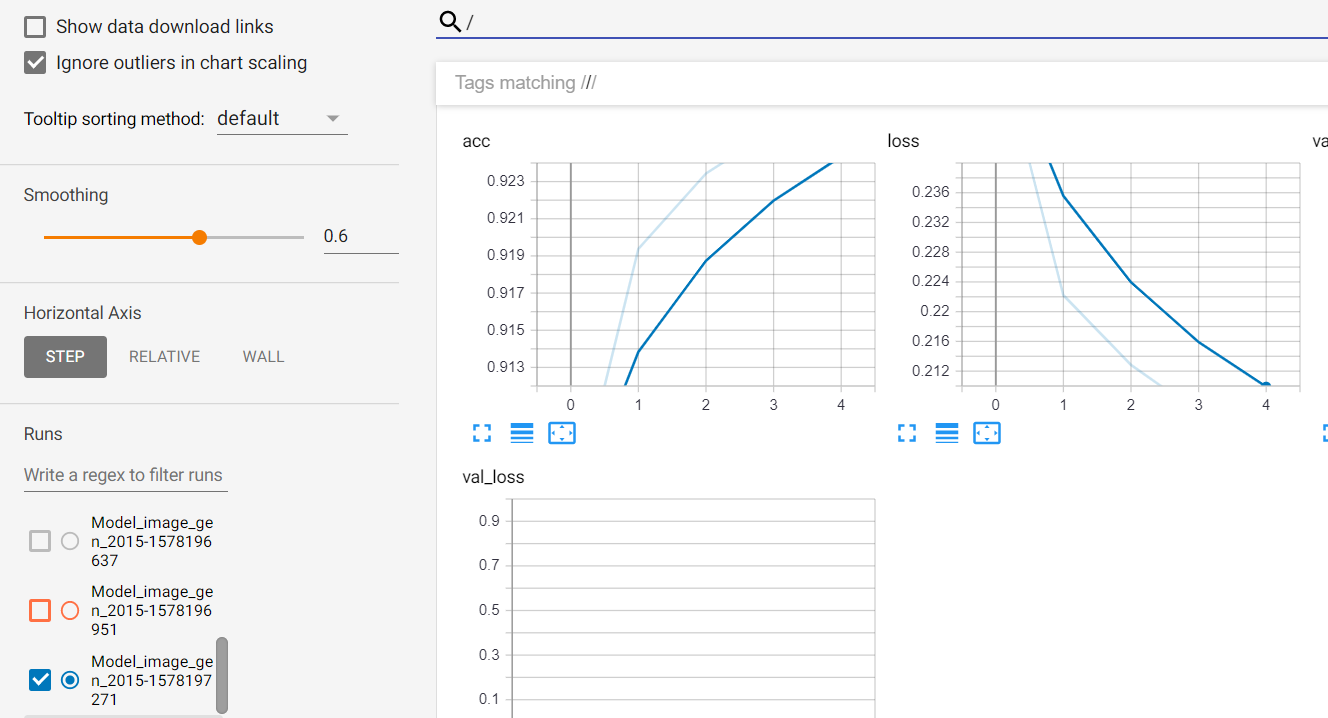

#### In the above cell we have trained Densent-121 architecture model on the image data from 2015's Kaggle competetion and saved the weights from it

#### 2.4.4 Resnet50 on 2015's Data

In [24]:
from keras_applications.resnet import ResNet50

Name = "Model_image_gen_2015_resnet-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

resnet = ResNet50(weights='imagenet',
                       include_top=False,
                       backend=keras.backend,
                       layers=keras.layers,
                       models=keras.models,
                       utils=keras.utils,
                       input_shape=(224,224,3))
model_five_2 = Sequential()
model_five_2.add(resnet)
model_five_2.add(GlobalAveragePooling2D())
model_five_2.add(Dropout(0.5))
model_five_2.add(Dense(5, activation='sigmoid'))
    
model_five_2.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy'])
    
filepath="weights_image_gen_2015_resnet.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard] 

model_five_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [42]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS

11070

In [44]:
history_five_2 =model_five_2.fit_generator(train_generator, 
                    steps_per_epoch = NUM_TRAIN_STEPS,
                    epochs=3,
                    initial_epoch=0,
                    verbose=2,
                    callbacks=callbacks_list)



Epoch 1/3
 - 3980s - loss: 0.2448 - acc: 0.9089

Epoch 00001: acc improved from -inf to 0.90889, saving model to weights_image_gen_2015_resnet.hdf5
Epoch 2/3
 - 3972s - loss: 0.2200 - acc: 0.9187

Epoch 00002: acc improved from 0.90889 to 0.91871, saving model to weights_image_gen_2015_resnet.hdf5
Epoch 3/3
 - 3976s - loss: 0.2127 - acc: 0.9221

Epoch 00003: acc improved from 0.91871 to 0.92211, saving model to weights_image_gen_2015_resnet.hdf5


#### 2.4.5 Efficient-Net B0 on 2015's data.

In [25]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB4(weights='imagenet')

In [15]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

Name = "Model_image_gen_2015_effnet-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

effnet = efn.EfficientNetB0(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_five_3 = Sequential()
model_five_3.add(effnet)
model_five_3.add(GlobalAveragePooling2D())
model_five_3.add(Dropout(0.5))
model_five_3.add(Dense(5, activation='sigmoid'))
    
model_five_3.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy'])
    
filepath="weights_image_gen_2015_effnet.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard] 

model_five_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [17]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS

11070

In [ ]:
history_five_3 =model_five_3.fit_generator(train_generator, 
                    steps_per_epoch = NUM_TRAIN_STEPS,
                    epochs=5,
                    initial_epoch=0,
                    verbose=2,
                    callbacks=callbacks_list)#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS



Epoch 1/5
 - 2951s - loss: 0.2548 - acc: 0.9050

Epoch 00001: acc improved from -inf to 0.90495, saving model to weights_image_gen_2015_effnet.hdf5
Epoch 2/5
 - 2892s - loss: 0.2240 - acc: 0.9170

Epoch 00002: acc improved from 0.90495 to 0.91701, saving model to weights_image_gen_2015_effnet.hdf5
Epoch 3/5


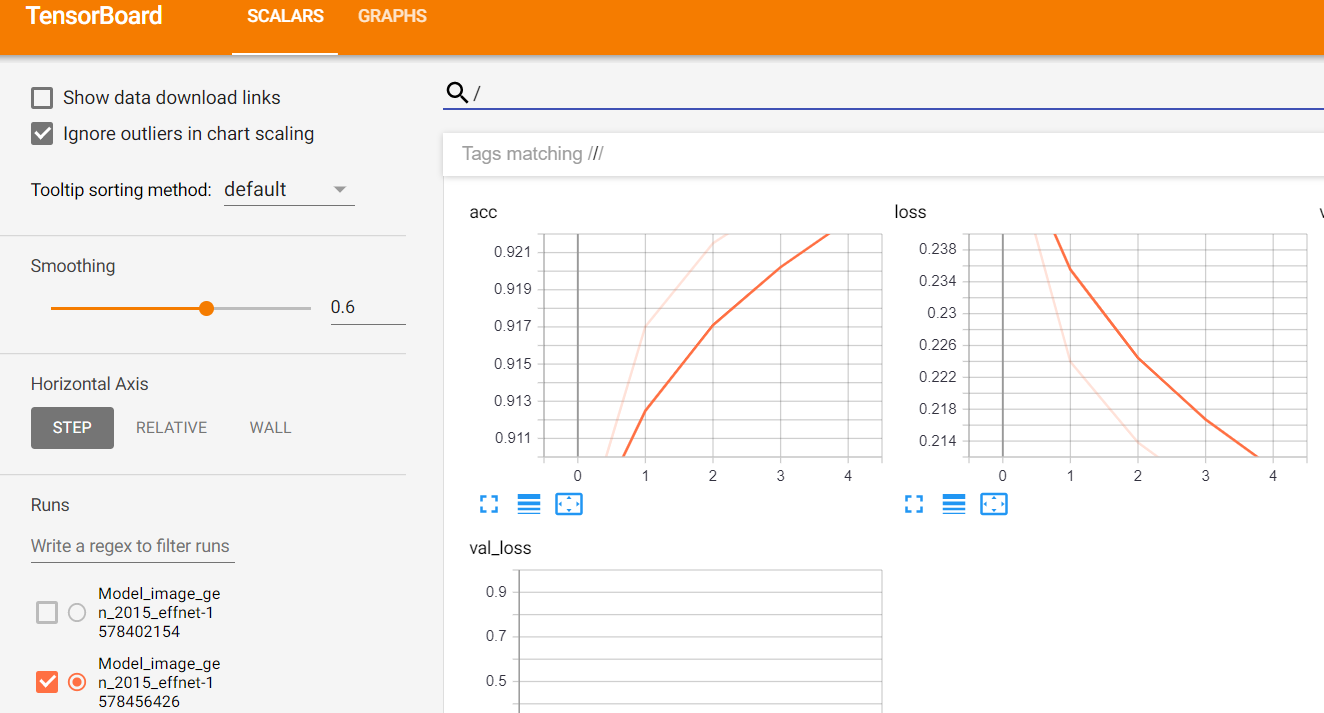

#### 2.4.6 Efficient-Net B3 on 2015's data.

In [33]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB3(weights='imagenet')

In [26]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

Name = "Model_image_gen_2015_effnet_B3-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

effnet = efn.EfficientNetB3(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_five_4 = Sequential()
model_five_4.add(effnet)
model_five_4.add(GlobalAveragePooling2D())
model_five_4.add(Dropout(0.5))
model_five_4.add(Dense(5, activation='sigmoid'))
    
model_five_4.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy'])
    
filepath="weights_image_gen_2015_effnet_B3.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard] 

model_five_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
_________________________________________________________________


In [37]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS

11070

In [38]:
history_five_4 =model_five_4.fit_generator(train_generator, 
                    steps_per_epoch = NUM_TRAIN_STEPS,
                    epochs=5,
                    initial_epoch=0,
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/5
 - 5634s - loss: 0.2435 - acc: 0.9098

Epoch 00001: acc improved from -inf to 0.90975, saving model to weights_image_gen_2015_effnet_B3.hdf5
Epoch 2/5
 - 10502s - loss: 0.2156 - acc: 0.9213

Epoch 00002: acc improved from 0.90975 to 0.92132, saving model to weights_image_gen_2015_effnet_B3.hdf5
Epoch 3/5
 - 5620s - loss: 0.2070 - acc: 0.9249

Epoch 00003: acc improved from 0.92132 to 0.92487, saving model to weights_image_gen_2015_effnet_B3.hdf5
Epoch 4/5
 - 5621s - loss: 0.2008 - acc: 0.9271

Epoch 00004: acc improved from 0.92487 to 0.92711, saving model to weights_image_gen_2015_effnet_B3.hdf5
Epoch 5/5
 - 5622s - loss: 0.1962 - acc: 0.9293

Epoch 00005: acc improved from 0.92711 to 0.92931, saving model to weights_image_gen_2015_effnet_B3.hdf5


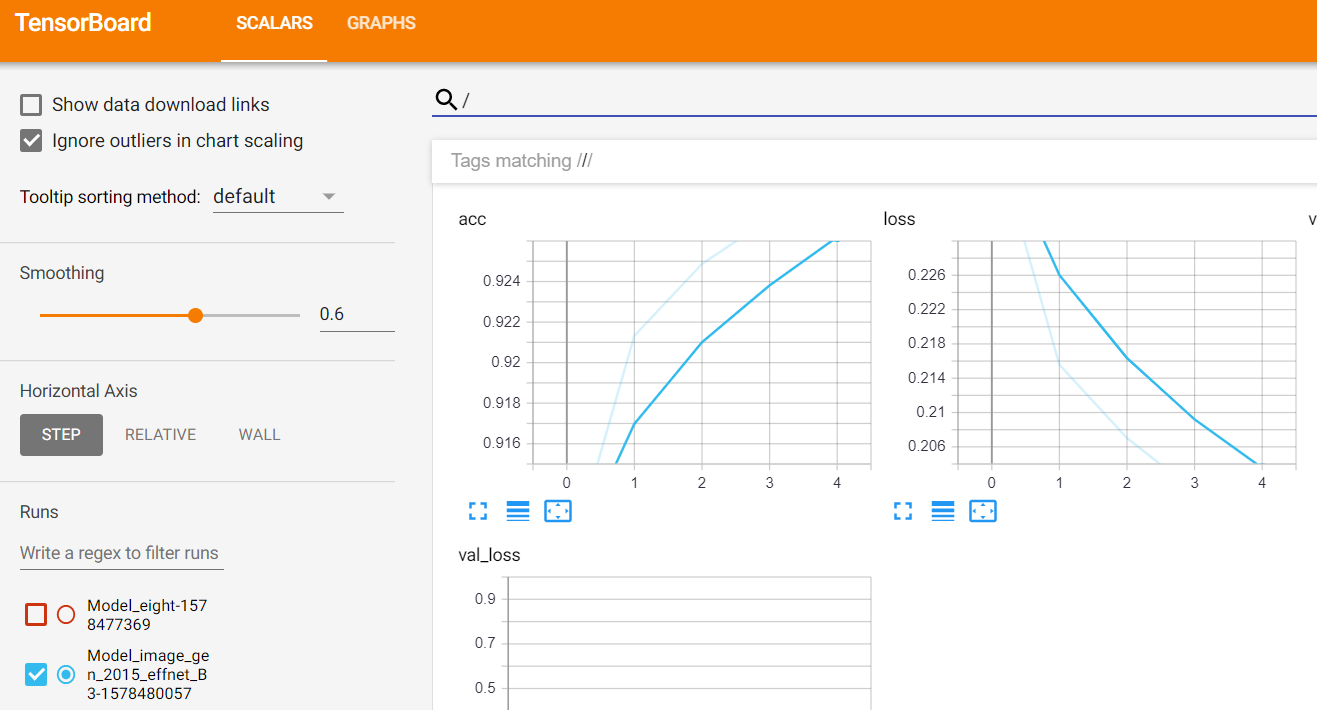

#### Efficient-Net B4 on 2015's data.

In [8]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB4(weights='imagenet')

In [9]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

Name = "Model_image_gen_2015_effnet_B4-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

effnet = efn.EfficientNetB4(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_five_5 = Sequential()
model_five_5.add(effnet)
model_five_5.add(GlobalAveragePooling2D())
model_five_5.add(Dropout(0.5))
model_five_5.add(Dense(5, activation='sigmoid'))
    
model_five_5.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy'])
    
filepath="weights_image_gen_2015_effnet_B4.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard] 

model_five_5.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [12]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
#NUM_VALID_STEPS = validation_generator.n // validation_generator.batch_size

NUM_TRAIN_STEPS

11070

In [13]:
history_five_5 =model_five_5.fit_generator(train_generator, 
                    steps_per_epoch = NUM_TRAIN_STEPS,
                    epochs=5,
                    initial_epoch=0,
                    verbose=2,
                    callbacks=callbacks_list)



Epoch 1/5
 - 7719s - loss: 0.2426 - acc: 0.9103

Epoch 00001: acc improved from -inf to 0.91026, saving model to weights_image_gen_2015_effnet_B4.hdf5
Epoch 2/5
 - 7520s - loss: 0.2142 - acc: 0.9219

Epoch 00002: acc improved from 0.91026 to 0.92193, saving model to weights_image_gen_2015_effnet_B4.hdf5
Epoch 3/5
 - 7524s - loss: 0.2051 - acc: 0.9258

Epoch 00003: acc improved from 0.92193 to 0.92578, saving model to weights_image_gen_2015_effnet_B4.hdf5
Epoch 4/5
 - 7520s - loss: 0.1993 - acc: 0.9279

Epoch 00004: acc improved from 0.92578 to 0.92791, saving model to weights_image_gen_2015_effnet_B4.hdf5
Epoch 5/5
 - 7525s - loss: 0.1952 - acc: 0.9298

Epoch 00005: acc improved from 0.92791 to 0.92976, saving model to weights_image_gen_2015_effnet_B4.hdf5


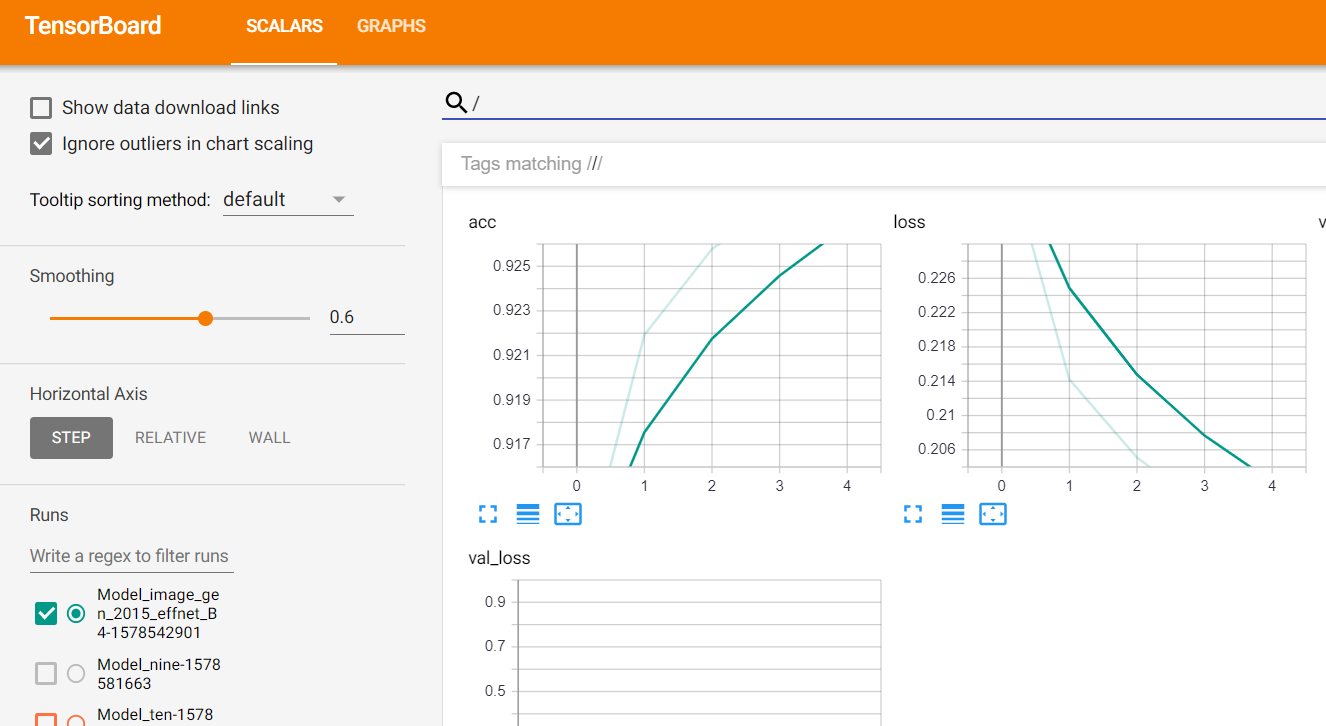

#### 2.5 TransferLearning with models pretrained on 2015's Data.

#### Using the weights obtained from Model-5 as the starting weights we shall fine tune our final model on 2019's competetion data.

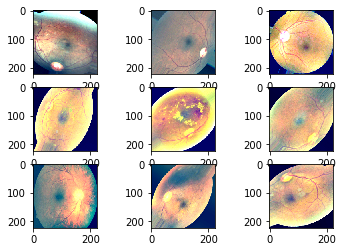

In [16]:
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_batch[i].astype('uint8'))
	# show the plot
	pyplot.show()
	break

#### 2.5.1 Densenet121 Pretrained on 2015's data and tuned on 2019's data.

In [28]:
from keras.applications import DenseNet121

Name = "Model_six-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

densenet = DenseNet121(weights=None,
                       include_top=False,
                       input_shape=(224,224,3))
model_six = Sequential()
model_six.add(densenet)
model_six.add(GlobalAveragePooling2D())
model_six.add(Dropout(0.5))
model_six.add(Dense(5, activation='sigmoid'))
    
model_six.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_six.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_six.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [29]:
#Load weights from model-5
model_six.load_weights('C:/Users/HP/Self_case_study-2/weights_image_gen_2015.hdf5')

In [30]:
history_six =model_six.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)

Epoch 1/30
389/389 [==============================] - 257s 661ms/step - loss: 0.2524 - kappa: nan - val_loss: 0.1944 - val_kappa: 0.7721

Epoch 00001: val_kappa improved from -inf to 0.77208, saving model to new_kappa_weights/weights_six.hdf5
Epoch 2/30
389/389 [==============================] - 154s 395ms/step - loss: 0.1438 - kappa: 0.8657 - val_loss: 0.1533 - val_kappa: 0.8133

Epoch 00002: val_kappa improved from 0.77208 to 0.81327, saving model to new_kappa_weights/weights_six.hdf5
Epoch 3/30
389/389 [==============================] - 153s 394ms/step - loss: 0.1292 - kappa: 0.8786 - val_loss: 0.1310 - val_kappa: 0.8529

Epoch 00003: val_kappa improved from 0.81327 to 0.85287, saving model to new_kappa_weights/weights_six.hdf5
Epoch 4/30
389/389 [==============================] - 152s 391ms/step - loss: 0.1248 - kappa: nan - val_loss: 0.1511 - val_kappa: 0.8424

Epoch 00004: val_kappa did not improve from 0.85287
Epoch 5/30
389/389 [==============================] - 152s 392ms/step

In [31]:
model_six.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_six.h5')
#model_six = load_model('new_kappa_models/model_six.h5')

In [35]:
model_six.load_weights(filepath)
score_six = model_six.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_six[0])
print('Test kappa:', score_six[1])

Test loss: 0.12704402295025913
Test kappa: 0.9076770741289312


In [33]:
y_pred = model_six.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  14.545454545454545
-------------------------------------------------- Confusion matrix --------------------------------------------------


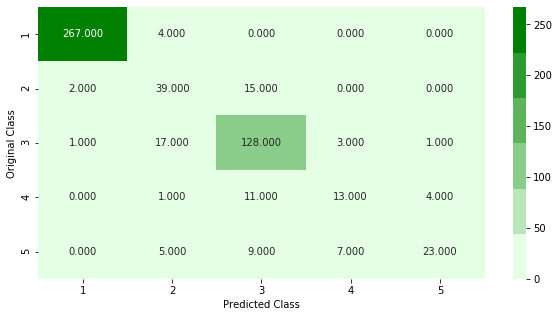

-------------------------------------------------- Precision matrix --------------------------------------------------


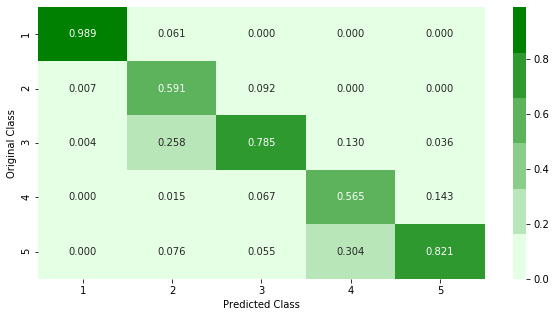

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


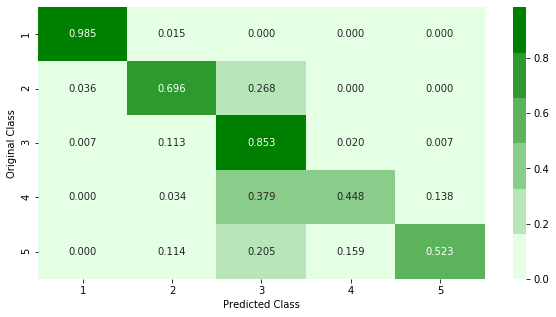

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [34]:
plot_confusion_matrix(actual_y, y_pred)

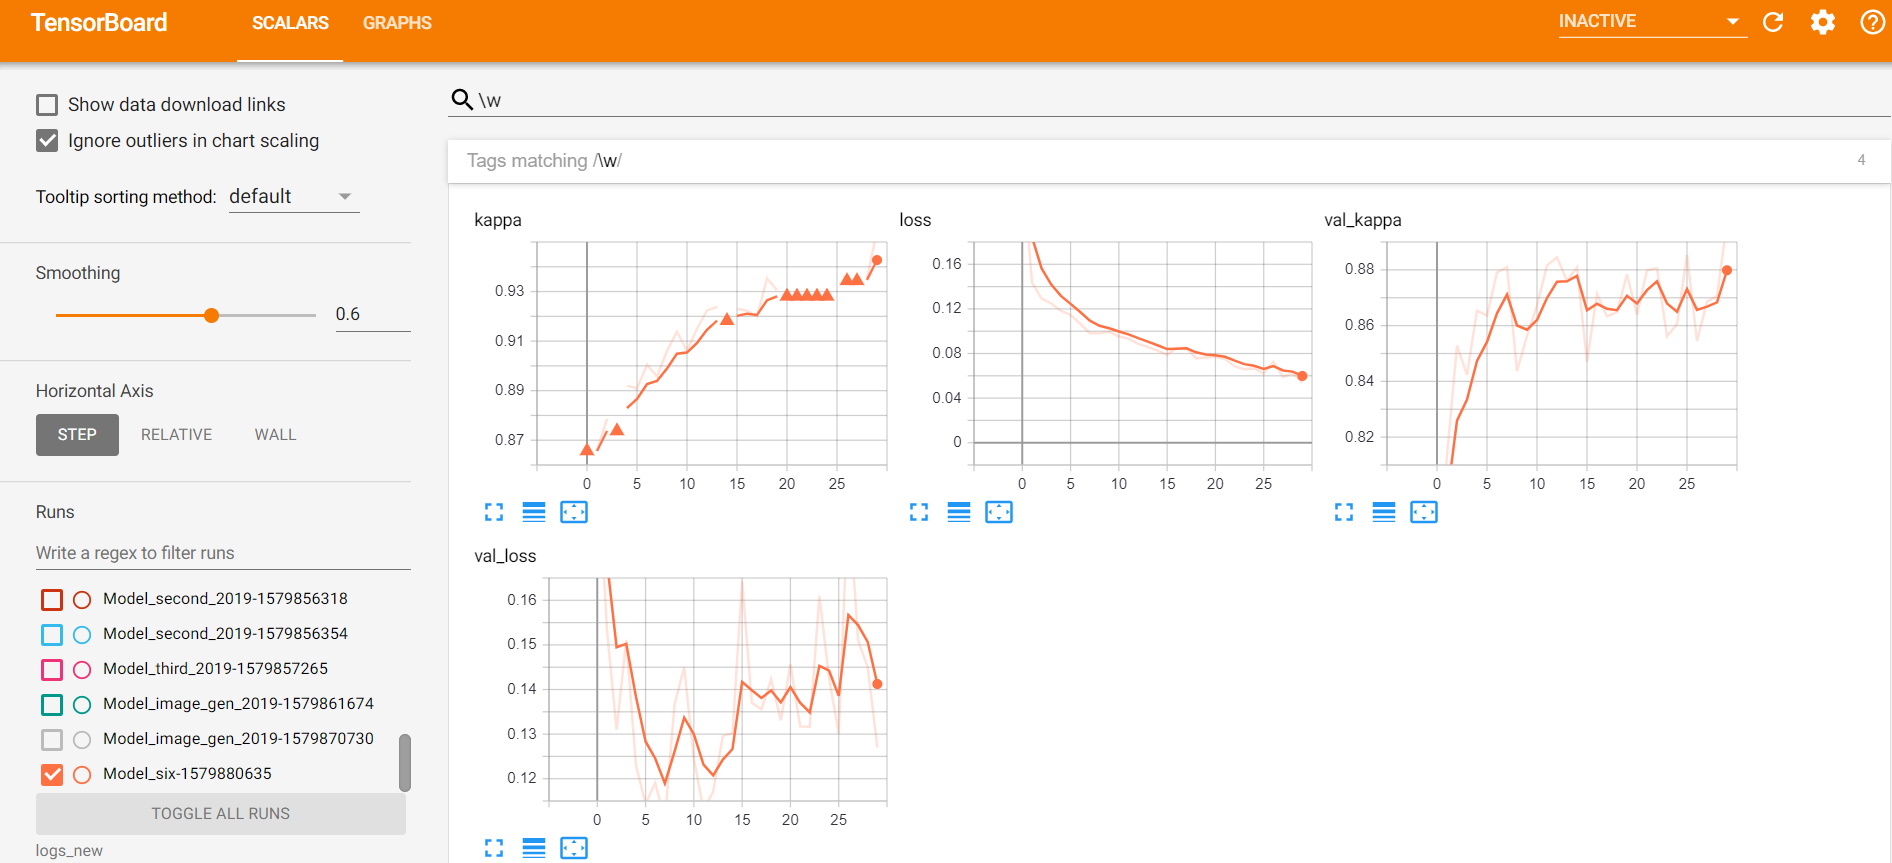

#### From the above matrices and tensorboard graphs we can see that the model-six which uses model which is pretrained on 2015's competetion data is mostly similar to the one which is trained just on 2019's data but the loss, accuracy and most importantly the kappa score is highest in the model-six at 91.34 

#### 2.5.2 Resnet50 Pretrained on 2015's data and tuned on 2019's data.

In [17]:
from keras_applications.resnet import ResNet50

Name = "Model_seven-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

resnet = ResNet50(weights='imagenet',
                       include_top=False,
                       backend=keras.backend,
                       layers=keras.layers,
                       models=keras.models,
                       utils=keras.utils,
                       input_shape=(224,224,3))
model_seven = Sequential()
model_seven.add(resnet)
model_seven.add(GlobalAveragePooling2D())
model_seven.add(Dropout(0.5))
model_seven.add(Dense(5, activation='sigmoid'))
    
model_seven.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_seven.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_seven.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
#Load weights from model-5
model_seven.load_weights('C:/Users/HP/Self_case_study-2/weights_image_gen_2015_resnet.hdf5')

In [19]:
history_seven =model_seven.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)





Epoch 1/30
389/389 [==============================] - 168s 432ms/step - loss: 0.2283 - kappa: nan - val_loss: 0.1489 - val_kappa: 0.8260

Epoch 00001: val_kappa improved from -inf to 0.82605, saving model to new_kappa_weights/weights_seven.hdf5

Epoch 2/30
389/389 [==============================] - 152s 390ms/step - loss: 0.1482 - kappa: 0.8446 - val_loss: 0.1531 - val_kappa: 0.8401

Epoch 00002: val_kappa improved from 0.82605 to 0.84010, saving model to new_kappa_weights/weights_seven.hdf5
Epoch 3/30
389/389 [==============================] - 151s 389ms/step - loss: 0.1302 - kappa: 0.8645 - val_loss: 0.1606 - val_kappa: 0.8134

Epoch 00003: val_kappa did not improve from 0.84010
Epoch 4/30
389/389 [==============================] - 151s 389ms/step - loss: 0.1192 - kappa: 0.8783 - val_loss: 0.1644 - val_kappa: 0.8076

Epoch 00004: val_kappa did not improve from 0.84010
Epoch 5/30
389/389 [==============================] - 151s 389ms/step - loss: 0.1139 - kappa: nan - val_loss: 0.1

In [20]:
model_seven.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_seven.h5')
#model_seven = load_model('new_kappa_models/model_seven.h5')

In [21]:
model_seven.load_weights(filepath)
score_seven = model_seven.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_seven[0])
print('Test kappa:', score_seven[1])

Test loss: 0.11255994085561145
Test kappa: 0.9054127016934481


In [22]:
y_pred = model_seven.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  17.454545454545457
-------------------------------------------------- Confusion matrix --------------------------------------------------


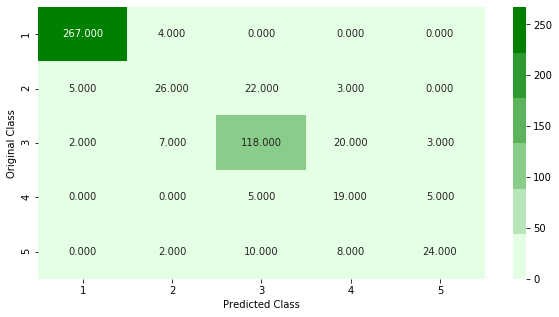

-------------------------------------------------- Precision matrix --------------------------------------------------


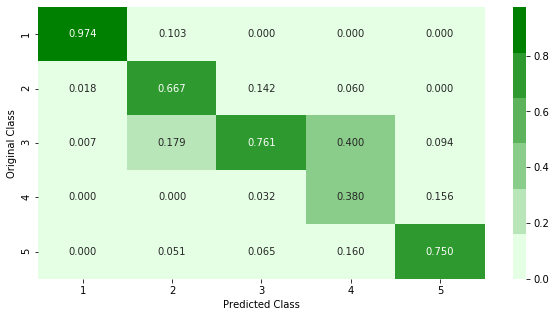

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


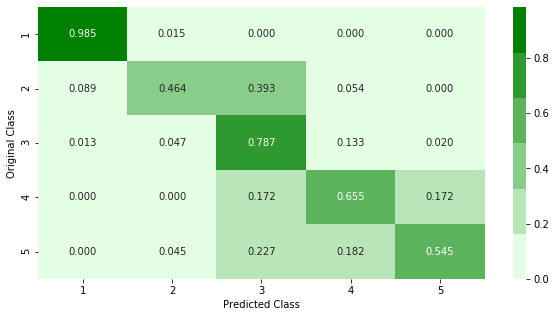

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [23]:
plot_confusion_matrix(actual_y, y_pred)

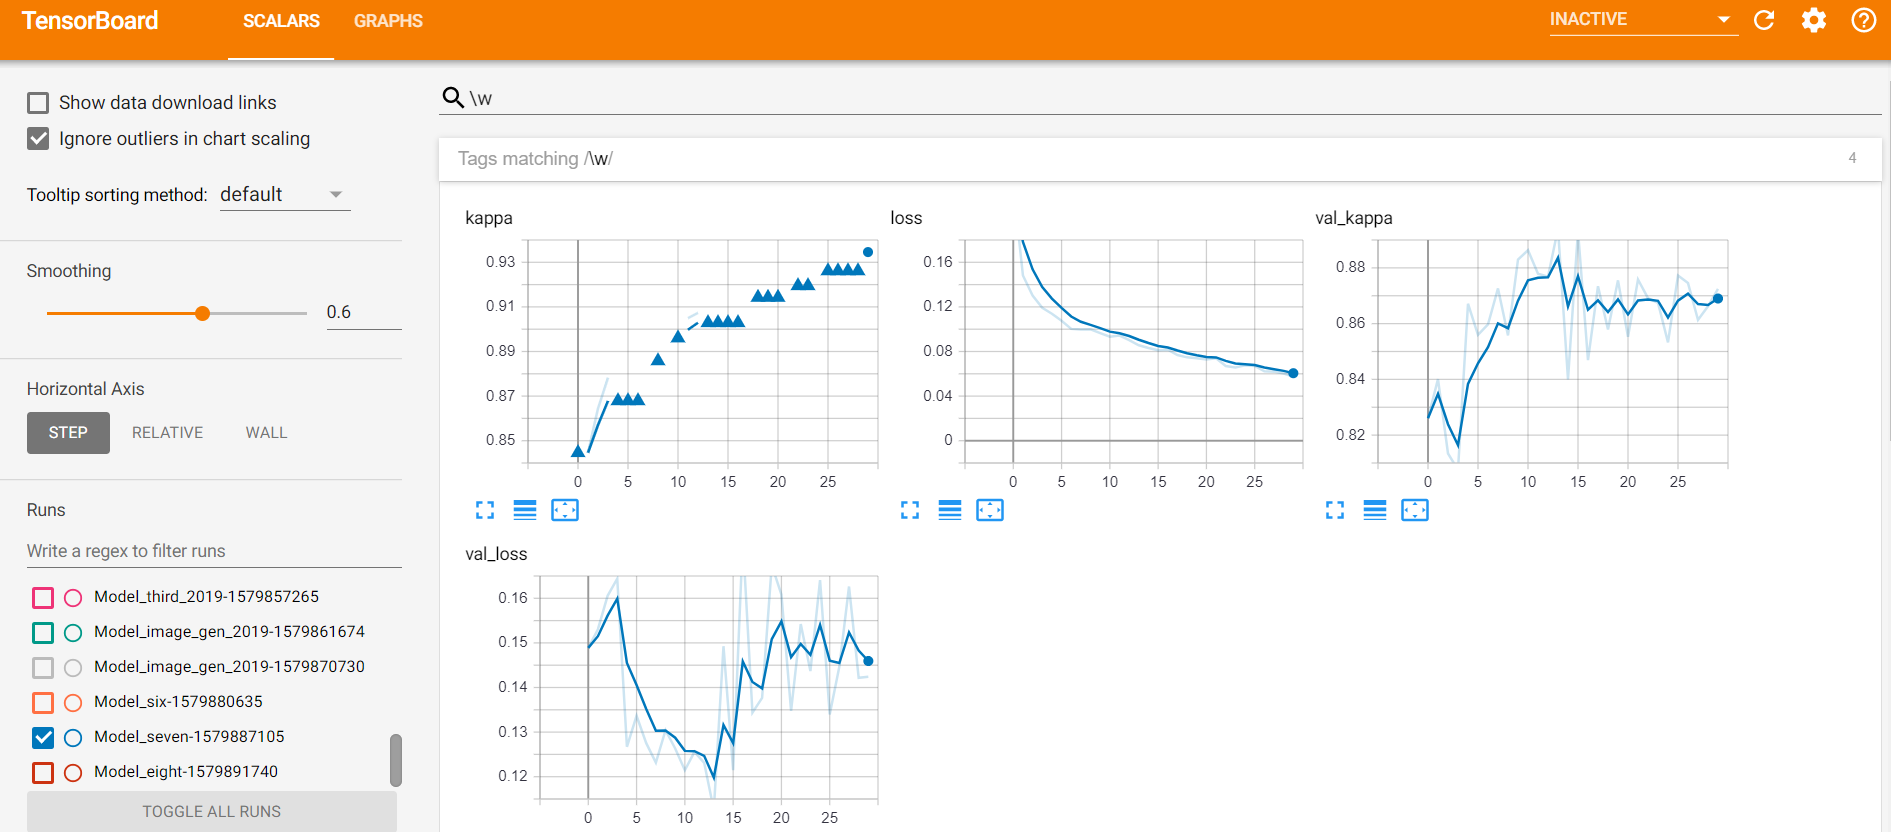

#### 2.5.3 EffnetB0 Pretrained on 2015's data and tuned on 2019's data.

In [24]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB0(weights='imagenet')

In [25]:
Name = "Model_eight-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

effnet = efn.EfficientNetB0(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_eight = Sequential()
model_eight.add(effnet)
model_eight.add(GlobalAveragePooling2D())
model_eight.add(Dropout(0.5))
model_eight.add(Dense(5, activation='sigmoid'))
    
model_eight.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_eight.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_eight.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [26]:
#Load weights from model-5
model_eight.load_weights('C:/Users/HP/Self_case_study-2/weights_image_gen_2015_effnet.hdf5')

In [27]:
history_eight =model_eight.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)

Epoch 1/30
389/389 [==============================] - 116s 297ms/step - loss: 0.2580 - kappa: 0.7603 - val_loss: 0.2083 - val_kappa: 0.7619

Epoch 00001: val_kappa improved from -inf to 0.76191, saving model to new_kappa_weights/weights_eight.hdf5
Epoch 2/30
389/389 [==============================] - 100s 257ms/step - loss: 0.1564 - kappa: 0.8494 - val_loss: 0.1665 - val_kappa: 0.8325

Epoch 00002: val_kappa improved from 0.76191 to 0.83253, saving model to new_kappa_weights/weights_eight.hdf5
Epoch 3/30
389/389 [==============================] - 100s 258ms/step - loss: 0.1365 - kappa: 0.8634 - val_loss: 0.1516 - val_kappa: 0.8412

Epoch 00003: val_kappa improved from 0.83253 to 0.84117, saving model to new_kappa_weights/weights_eight.hdf5
Epoch 4/30
389/389 [==============================] - 100s 258ms/step - loss: 0.1288 - kappa: 0.8757 - val_loss: 0.1349 - val_kappa: 0.8662

Epoch 00004: val_kappa improved from 0.84117 to 0.86622, saving model to new_kappa_weights/weights_eight.hdf5

In [28]:
model_eight.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_eight.h5')
#model_eight = load_model('new_kappa_models/model_eight.h5')

In [29]:
model_eight.load_weights(filepath)
score_eight = model_eight.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_eight[0])
print('Test kappa:', score_eight[1])

Test loss: 0.1287667587670413
Test accuracy: 0.902498863176866


In [30]:
y_pred = model_eight.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  18.181818181818183
-------------------------------------------------- Confusion matrix --------------------------------------------------


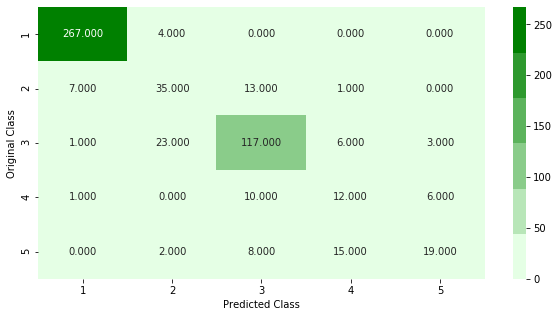

-------------------------------------------------- Precision matrix --------------------------------------------------


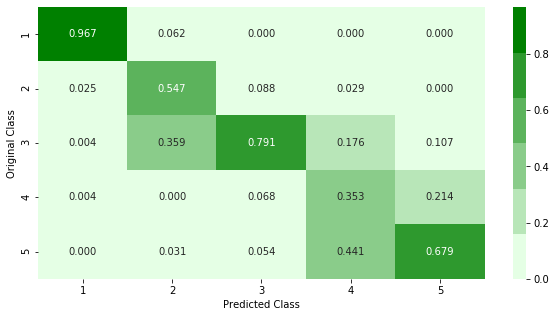

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


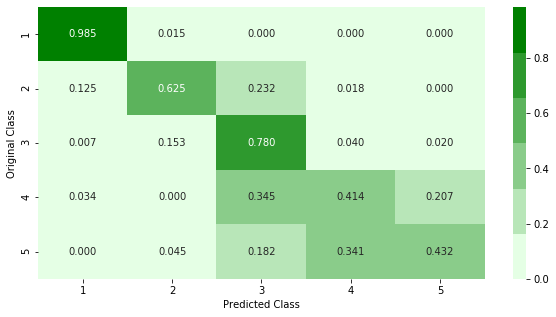

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [31]:
plot_confusion_matrix(actual_y, y_pred)

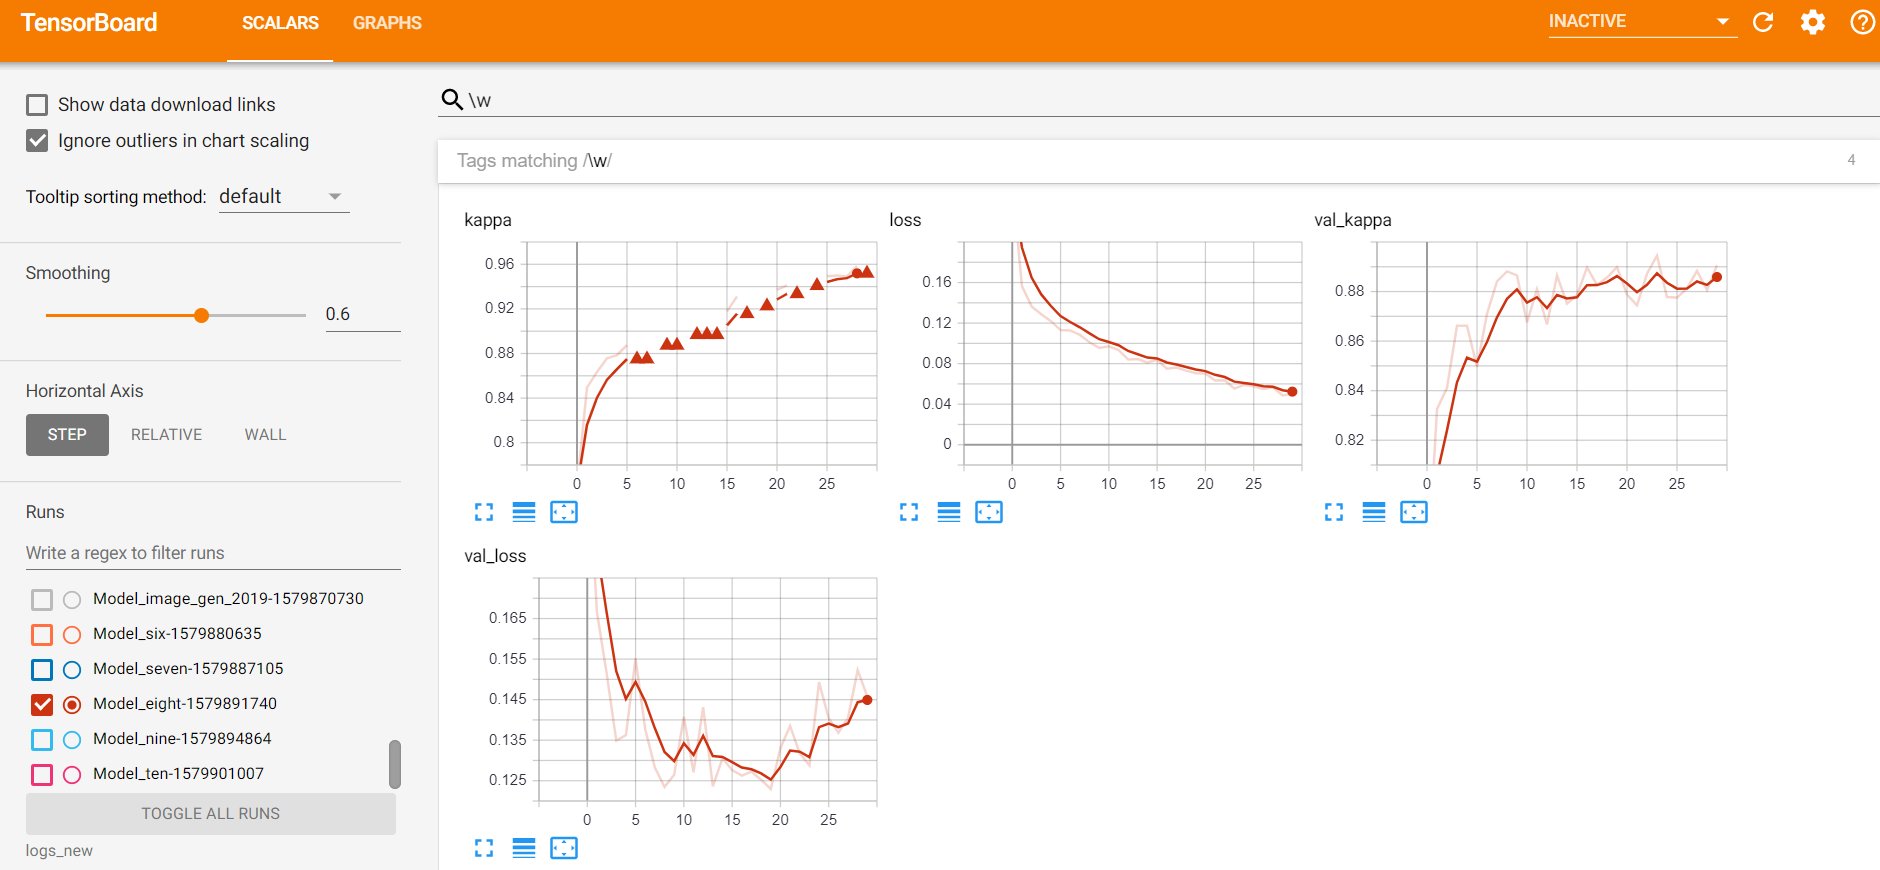

#### 2.5.4 EffnetB3 Pretrained on 2015's data and tuned on 2019's data.

In [32]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB3(weights='imagenet')

In [33]:
Name = "Model_nine-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

effnet = efn.EfficientNetB3(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_nine = Sequential()
model_nine.add(effnet)
model_nine.add(GlobalAveragePooling2D())
model_nine.add(Dropout(0.5))
model_nine.add(Dense(5, activation='sigmoid'))
    
model_nine.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_nine.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_nine.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
_________________________________________________________________


In [34]:
#Load weights from model-5
model_nine.load_weights('C:/Users/HP/Self_case_study-2/weights_image_gen_2015_effnet_B3.hdf5')

In [35]:
history_nine =model_nine.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)

Epoch 1/30
389/389 [==============================] - 225s 578ms/step - loss: 0.2366 - kappa: nan - val_loss: 0.1679 - val_kappa: 0.8274

Epoch 00001: val_kappa improved from -inf to 0.82742, saving model to new_kappa_weights/weights_nine.hdf5
Epoch 2/30
389/389 [==============================] - 194s 500ms/step - loss: 0.1460 - kappa: 0.8513 - val_loss: 0.1492 - val_kappa: 0.8403

Epoch 00002: val_kappa improved from 0.82742 to 0.84034, saving model to new_kappa_weights/weights_nine.hdf5
Epoch 3/30
389/389 [==============================] - 195s 500ms/step - loss: 0.1219 - kappa: 0.8869 - val_loss: 0.1348 - val_kappa: 0.8755

Epoch 00003: val_kappa improved from 0.84034 to 0.87545, saving model to new_kappa_weights/weights_nine.hdf5
Epoch 4/30
389/389 [==============================] - 195s 501ms/step - loss: 0.1173 - kappa: nan - val_loss: 0.1365 - val_kappa: 0.8781

Epoch 00004: val_kappa improved from 0.87545 to 0.87811, saving model to new_kappa_weights/weights_nine.hdf5
Epoch 5/3

In [36]:
model_nine.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_nine.h5')
#model_nine = load_model('new_kappa_models/model_nine.h5')

In [37]:
model_nine.load_weights(filepath)
score_nine = model_nine.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_nine[0])
print('Test kappa:', score_nine[1])


Test loss: 0.10849631507288326
Test kappa: 0.9156678847833113


In [38]:
y_pred = model_nine.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  15.454545454545453
-------------------------------------------------- Confusion matrix --------------------------------------------------


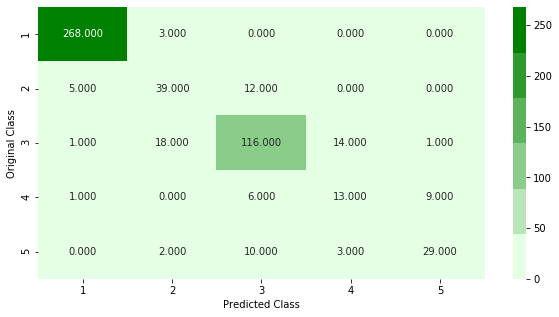

-------------------------------------------------- Precision matrix --------------------------------------------------


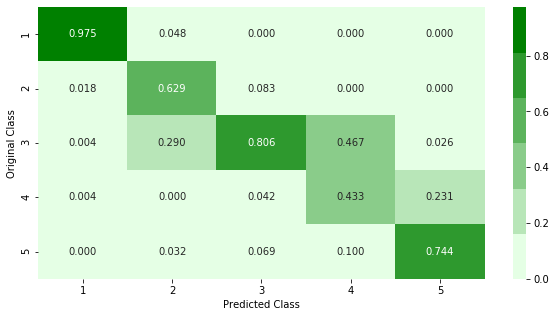

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


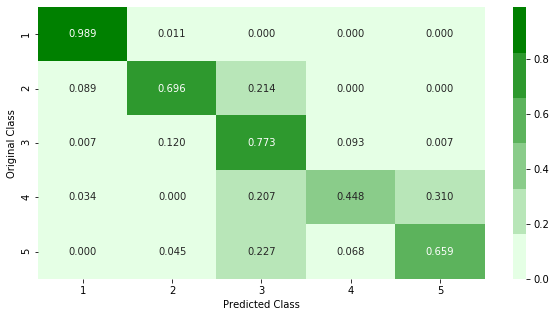

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [39]:
plot_confusion_matrix(actual_y, y_pred)

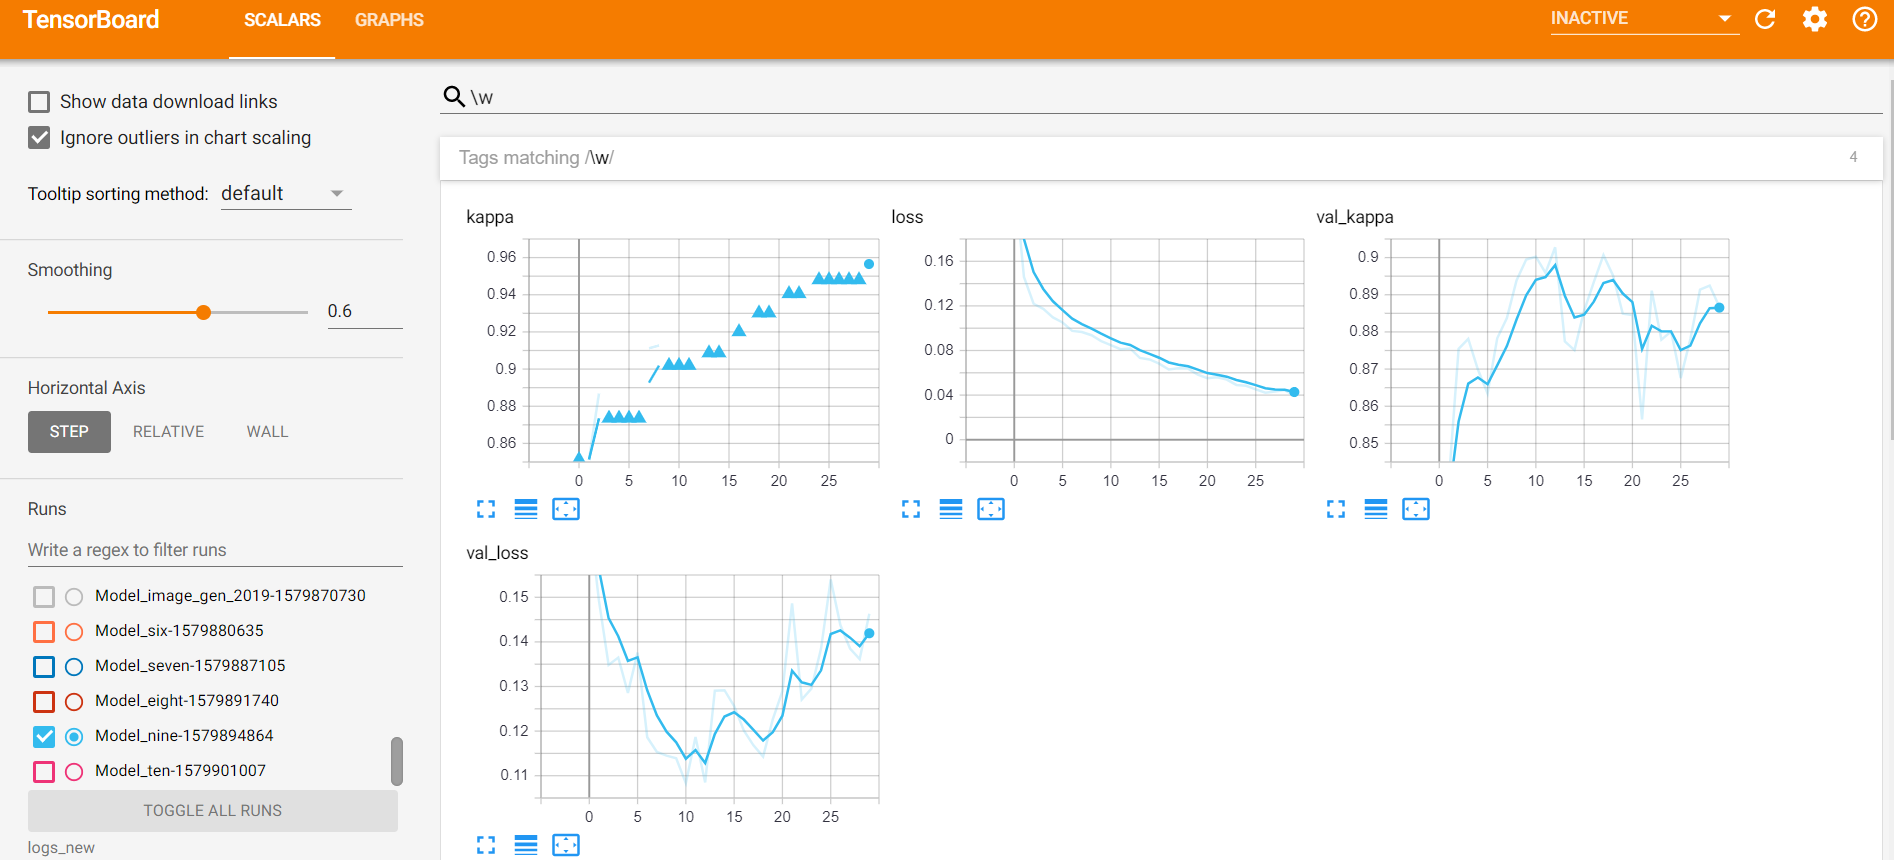

### From all the above models we can see that the Metrics function sometimes output nan instead of the actual value . 

### This is due to the small batch size as there are only 4 or 8 images(maximum that can be accomodated by GTX 1050) per batch most of them might belong to one or two of the 5 calsses due to which the normalization present in the cohen_kappa_score function goes for a toss and this also cannot be omitted.

### Hence we shall implement a callback function which predicts the kappa score on the validation set after each epoch in this final model and plot the progress of kappa score manually instead of using tensorboard.

###  we are also saving the best model which has the best Kappa score in Metrics() callback

In [17]:
'''
Custom Callback function defined to get cohen kappa score 
'''
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val,batch_size=8) > 0.5
        
        y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
        y_pred_ordinal[:,4] = y_pred[:,4]

        for i in range(3,-1,-1):
            y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i+1],y_pred_ordinal[:,i])
        
        y_pred = y_pred.astype(int).sum(axis=1) - 1
    
        _val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return _val_kappa

#### 2.5.5 EffnetB4 Pretrained on 2015's data and tuned on 2019's data.

In [18]:
#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

effnet = efn.EfficientNetB4(weights='imagenet')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [25]:
Name = "Model_ten-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

effnet = efn.EfficientNetB4(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_ten = Sequential()
model_ten.add(effnet)
model_ten.add(GlobalAveragePooling2D())
model_ten.add(Dropout(0.5))
model_ten.add(Dense(5, activation='sigmoid'))
    
model_ten.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        )
    
filepath="new_kappa_weights/weights_ten.hdf5"

#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

kappa_metrics = Metrics()
callbacks_list = [checkpoint] + [tensorboard] + [kappa_metrics]

model_ten.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1792)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [26]:
#Load weights from model-5
model_ten.load_weights('C:/Users/HP/Self_case_study-2/weights_image_gen_2015_effnet_B4.hdf5')

In [27]:
history_ten =model_ten.fit_generator(datagen.flow(x_train, y_train, batch_size=4), 
                    steps_per_epoch=len(x_train) / 4,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 4,
                    callbacks=callbacks_list)

Epoch 1/30
778/778 [==============================] - 330s 425ms/step - loss: 0.2319 - val_loss: 0.1798
val_kappa: 0.7993
Validation Kappa has improved. Saving model.
Epoch 2/30
778/778 [==============================] - 295s 379ms/step - loss: 0.1552 - val_loss: 0.1450
val_kappa: 0.8694
Validation Kappa has improved. Saving model.
Epoch 3/30
778/778 [==============================] - 295s 379ms/step - loss: 0.1317 - val_loss: 0.1388
val_kappa: 0.8810
Validation Kappa has improved. Saving model.
Epoch 4/30
778/778 [==============================] - 295s 379ms/step - loss: 0.1204 - val_loss: 0.1272
val_kappa: 0.8964
Validation Kappa has improved. Saving model.
Epoch 5/30
778/778 [==============================] - 294s 378ms/step - loss: 0.1155 - val_loss: 0.1303
val_kappa: 0.8959
Epoch 6/30
778/778 [==============================] - 295s 380ms/step - loss: 0.1074 - val_loss: 0.1515
val_kappa: 0.8722
Epoch 7/30
778/778 [==============================] - 295s 379ms/step - loss: 0.1055 - v

In [32]:
from keras.models import load_model
model_ten.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_ten.h5')
#model_ten = load_model('model_ten_kappa.h5')

In [33]:
#model_ten.load_weights(filepath)
score_ten = model_ten.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_ten[0])
print('Test kappa:', score_ten[1])

Test loss: 0.11334285860711878
Test kappa: 0.9632727241516114


In [34]:
y_pred = model_ten.predict(x_valid,batch_size=4) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  15.272727272727273
-------------------------------------------------- Confusion matrix --------------------------------------------------


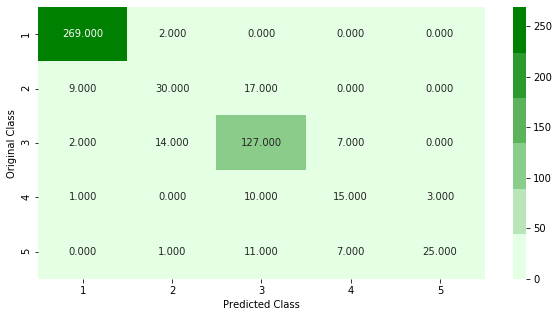

-------------------------------------------------- Precision matrix --------------------------------------------------


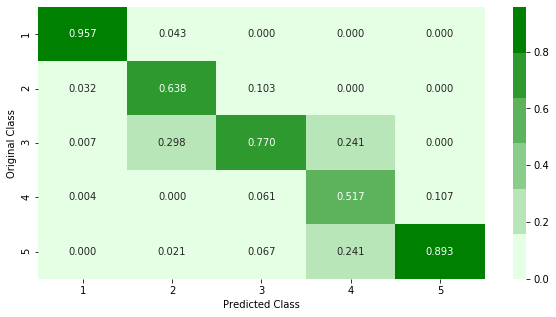

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


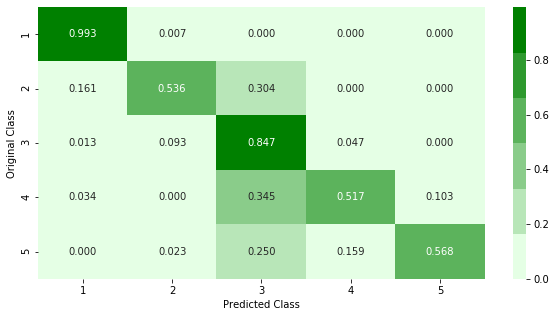

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [35]:
plot_confusion_matrix(actual_y, y_pred)

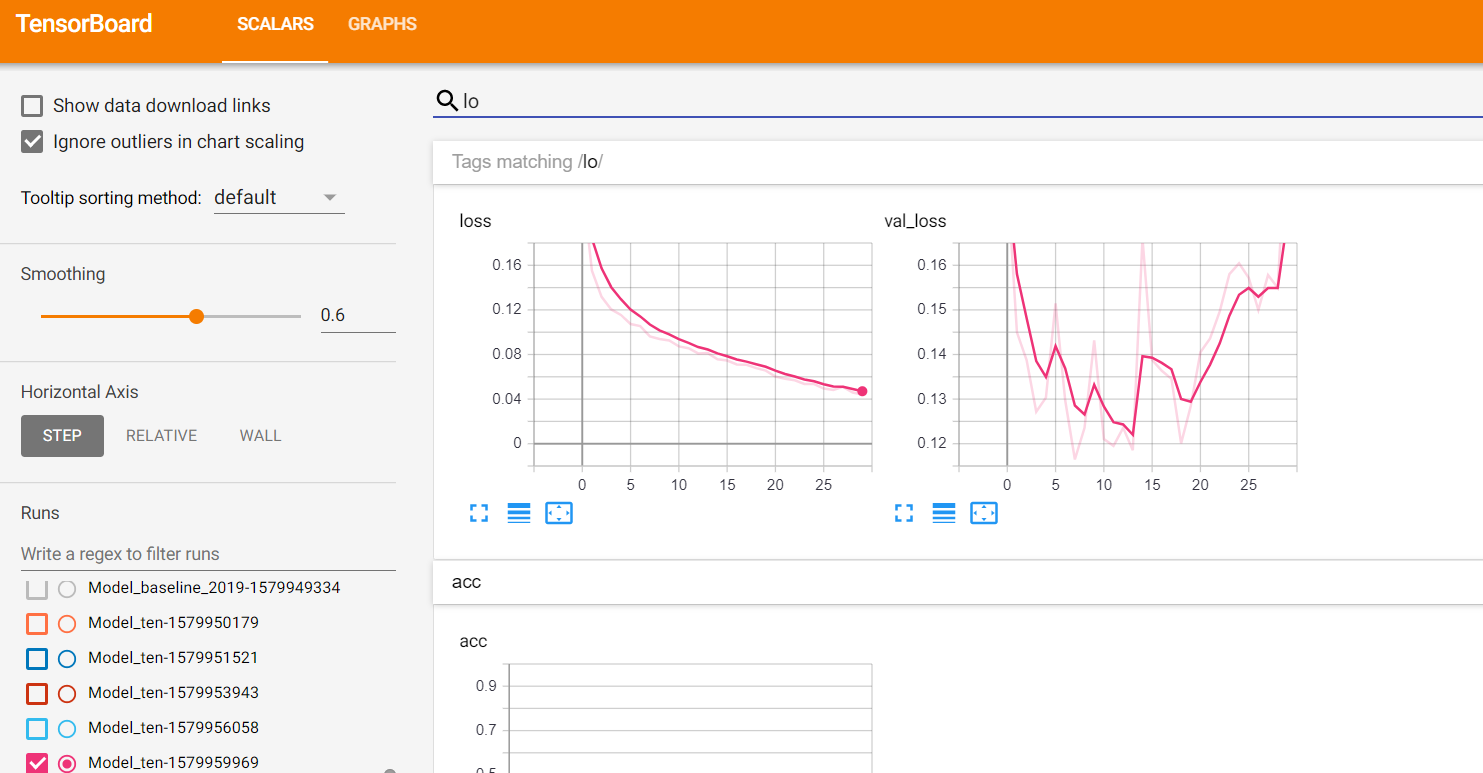

#### Plot for Validation Kappa Score

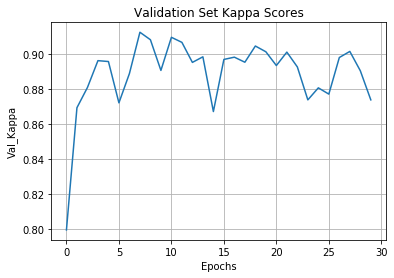

In [43]:
Val_kappa_scores= [0.7993,0.8694,0.8810,0.8964,0.8959,0.8722,0.8890,0.9127,0.9084,0.8908,0.9098,0.9069,0.8954,0.8986,0.8672,0.8971,0.8984,0.8955,0.9048,0.9015,0.8936,0.9013,0.8928,0.8739,0.8808,0.8772,0.8982,0.9017,0.8906,0.8739]

plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Val_Kappa")
plt.title("Validation Set Kappa Scores")
plt.plot(Val_kappa_scores)

#### 2.6 XGBoost On results of model-6,7,8,9,10.

#### Combining results from all the architectures above

The Idea here is to predict the output using models from 5 different architectures and feed them into an xgboost model.

#### 2.6.1 Loading and Predicting Best Models.

In [20]:
from keras.models import load_model
model_six = load_model('C:/Users/HP/Self_case_study-2/model_six_kappa.h5')
model_seven = load_model('C:/Users/HP/Self_case_study-2/model_seven_kappa.h5')
model_eight = load_model('C:/Users/HP/Self_case_study-2/model_eight_kappa.h5')
model_nine = load_model('C:/Users/HP/Self_case_study-2/model_nine_kappa.h5')
model_ten = load_model('C:/Users/HP/Self_case_study-2/model_ten_kappa.h5')

In [44]:
def predict_on_model_valid(model):
    '''
    This function takes in a model fits the validation set on it converts the preticted output variables into multiclass outputs
    '''
    y_pred = model.predict(x_valid,batch_size=8) > 0.5
    y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
    y_pred_ordinal[:,4] = y_pred[:,4]

    for i in range(3,-1,-1):
        y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])

    y_pred = y_pred_ordinal.sum(axis=1)-1
    
    return y_pred

In [42]:
def predict_on_model_train(model):
    '''
    This function takes in a model fits the train set on it converts the preticted output variables into multiclass outputs
    '''
    y_pred = model.predict(x_train,batch_size=8) > 0.5
    y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
    y_pred_ordinal[:,4] = y_pred[:,4]

    for i in range(3,-1,-1):
        y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])

    y_pred = y_pred_ordinal.sum(axis=1)-1
    
    return y_pred

In [45]:
y_pred_model_six_train = predict_on_model_train(model_six)
y_pred_model_six_valid = predict_on_model_valid(model_six)

y_pred_model_seven_train = predict_on_model_train(model_seven)
y_pred_model_seven_valid = predict_on_model_valid(model_seven)

y_pred_model_eight_train = predict_on_model_train(model_eight)
y_pred_model_eight_valid = predict_on_model_valid(model_eight)

y_pred_model_nine_train = predict_on_model_train(model_nine)
y_pred_model_nine_valid = predict_on_model_valid(model_nine)

y_pred_model_ten_train = predict_on_model_train(model_ten)
y_pred_model_ten_valid = predict_on_model_valid(model_ten)

In [41]:
actual_y_train = y_train.sum(axis=1) - 1 
actual_y_valid = y_valid.sum(axis=1) - 1 


In [29]:
type(actual_y)
type(y_pred_model_six)

numpy.ndarray

In [46]:
model_results_train = pd.DataFrame(np.stack((y_pred_model_six_train,y_pred_model_seven_train,\
                                       y_pred_model_eight_train,y_pred_model_nine_train,\
                                       y_pred_model_ten_train),axis=-1),\
                             columns = ['model_six_out','model_seven_out',\
                                        'model_eight_out','model_nine_out',\
                                        'model_ten_out'])
model_results_train.head()

model_six_out  model_seven_out  model_eight_out  model_nine_out  \
0              1                1                1               0   
1              1                1                1               1   
2              4                3                4               4   
3              2                2                4               2   
4              0                0                0               0   

   model_ten_out  
0              1  
1              1  
2              3  
3              1  
4              0

In [47]:
model_results_valid = pd.DataFrame(np.stack((y_pred_model_six_valid,y_pred_model_seven_valid,\
                                       y_pred_model_eight_valid,y_pred_model_nine_valid,\
                                       y_pred_model_ten_valid),axis=-1),\
                             columns = ['model_six_out','model_seven_out',\
                                        'model_eight_out','model_nine_out',\
                                        'model_ten_out'])
model_results_valid.head()

model_six_out  model_seven_out  model_eight_out  model_nine_out  \
0              0                0                0               0   
1              2                1                2               1   
2              4                2                1               3   
3              0                0                0               0   
4              1                1                2               1   

   model_ten_out  
0              0  
1              2  
2              3  
3              0  
4              1

#### 2.6.2 XGboost on outputs from best models.

log_loss for c =  10 is 0.5251801939372479
log_loss for c =  50 is 0.5198885700518212
log_loss for c =  100 is 0.5209885711623755
log_loss for c =  500 is 0.514958296857105
log_loss for c =  1000 is 0.5140750310582818
log_loss for c =  3000 is 0.5192023795298731
log_loss for c =  5000 is 0.5228764822759832


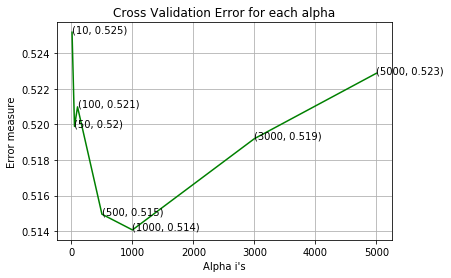

For values of best alpha =  1000 The train log loss is: 0.2526107203811295
For values of best alpha =  1000 The cross validation log loss is: 0.5192023795298731


In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

#appliedaicourse
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,1500]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(model_results_train,actual_y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(model_results_train,actual_y_train)
    predict_y = sig_clf.predict_proba(model_results_valid)
    cv_log_error_array.append(log_loss(actual_y_valid, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=3000,nthread=-1)
x_cfl.fit(model_results_train,actual_y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(model_results_train,actual_y_train)

predict_y = sig_clf.predict_proba(model_results_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(actual_y_train, predict_y))
predict_y = sig_clf.predict_proba(model_results_valid)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(actual_y_valid, predict_y))


In [57]:
predict_y = sig_clf.predict(model_results_valid)
validation_kappa = cohen_kappa_score(actual_y_valid, predict_y, weights='quadratic')

print(validation_kappa)

0.9201096219910327


#### The above cells show that the Validation Kappa score has not improved from what was achieved by Model-10, hence we shall try and fine tune the XGBclassifier to improve the score.

#### 2.6.3 Gridsearch on XGBoost.

In [62]:
from sklearn.model_selection import GridSearchCV

x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,1300,1500],
     'max_depth':[1,2],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=GridSearchCV(x_cfl,prams,verbose=10,n_jobs=-1,)
random_cfl.fit(model_results_train,actual_y_train)
print (random_cfl.best_params_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

{'colsample_bytree': 1, 'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 1500, 'subsample': 0.1}


In [60]:
x_cfl=XGBClassifier(n_estimators=100,max_depth=1,learning_rate=0.1,colsample_bytree=1,subsample=1,nthread=-1)
x_cfl.fit(model_results_train,actual_y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(model_results_train,actual_y_train)

predict_y = sig_clf.predict_proba(model_results_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(actual_y_train, predict_y))
predict_y = sig_clf.predict_proba(model_results_valid)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(actual_y_valid, predict_y))



For values of best alpha =  1000 The train log loss is: 0.28541635777313934
For values of best alpha =  1000 The cross validation log loss is: 0.5274833387570803


In [63]:
predict_y = sig_clf.predict(model_results_valid)
validation_kappa = cohen_kappa_score(actual_y_valid, predict_y, weights='quadratic')

print(validation_kappa)

0.9200640690245511


#### From the above cells we can see that the validation Kppa score has not improved hence we will revert back to Model-10.

#### 3. Conclusion 

In [3]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable


    
x = PrettyTable()


x.add_column('Model',['Model_base','Model_two','Model_three','Model_four',\
                      'model_six','model_seven','model_eight','model_nine','model_ten','XGB'])
x.add_column('trainable params',['2,814,949','12,910,245','6,958,981','6,958,981',\
                                 '6,958,981','23,544,837','4,013,953','10,703,917','17,557,581','-'])
x.add_column('train_acc',[0.9154,0.9305,0.9948,0.972,0.9706,0.9623,0.9736,0.9600,0.9557,'-'])
x.add_column('val_acc',[0.9102,0.9193,0.9545,0.9589,0.9604,0.9567,0.9571,0.9600,0.9633,'-'])
x.add_column('val_kappa',[0.7258,0.7732,0.9095,0.9121,0.9134,0.9165,0.9085,0.9156,0.9201,0.9201])



print(x)
print("Model_three= densenet121 with imagenet weights")
print("Model_four= densenet121 with imagenet weights and Image Augmentation")
print("Model_six= densenet121 with model 5a weights(trained on 2015's data) and Image Augmentation")
print("Model_seven= resnet50 with model 5b weights(trained on 2015's data) and Image Augmentation")
print("Model_eight= effnetB0 with model 5c weights(trained on 2015's data) and Image Augmentation")
print("Model_nine= effnetB3 with model 5d weights(trained on 2015's data) and Image Augmentation")
print("Model_ten= effnetB4 with model 5e weights(trained on 2015's data) and Image Augmentation")

x.clear()

+-------------+------------------+-----------+---------+-----------+
|    Model    | trainable params | train_acc | val_acc | val_kappa |
+-------------+------------------+-----------+---------+-----------+
|  Model_base |    2,814,949     |   0.9154  |  0.9102 |   0.7258  |
|  Model_two  |    12,910,245    |   0.9305  |  0.9193 |   0.7732  |
| Model_three |    6,958,981     |   0.9948  |  0.9545 |   0.9095  |
|  Model_four |    6,958,981     |   0.972   |  0.9589 |   0.9121  |
|  model_six  |    6,958,981     |   0.9706  |  0.9604 |   0.9134  |
| model_seven |    23,544,837    |   0.9623  |  0.9567 |   0.9165  |
| model_eight |    4,013,953     |   0.9736  |  0.9571 |   0.9085  |
|  model_nine |    10,703,917    |    0.96   |   0.96  |   0.9156  |
|  model_ten  |    17,557,581    |   0.9557  |  0.9633 |   0.9201  |
|     XGB     |        -         |     -     |    -    |   0.9201  |
+-------------+------------------+-----------+---------+-----------+
Model_three= densenet121 with imag

#### After all the experiments model-10 has proved to be the best 

#### Model-10 is an EffnetB4 which uses weights from Model-5e which is trained on 2015's comptetion data and has imagenet weights to begin with.

#### Also note that Effnet-B4 has around 17.5M parameters which is lesser than the second best architecture Resnet50 which has around 23.5M parameters.

#### Creating Test Labels.

In [ ]:
if os.path.exists('D:/Blindness Detection/x_test_224_2019.npy'):
    x_test = np.load("D:/Blindness Detection/x_test_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_test = Preprocessing_images(df=df_test['id_code'], sub_dir='test_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_test_224_2019.npy', arr=x_test)

print(x_test.shape)

In [ ]:
y_pred = model_six.predict(x_test,batch_size=4) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.astype(int).sum(axis=1)-1

In [ ]:
df_test['diagnosis'] = y_pred
df_test.to_csv('submission.csv',index=False)

References:
1. https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter
2. https://en.wikipedia.org/wiki/Cohen%27s_kappa
3. https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
4. https://github.com/btgraham/SparseConvNet/blob/kaggle_Diabetic_Retinopathy_competition/competitionreport.pdf
5. https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images/version/1#trainLabels15.csv
6. https://arxiv.org/pdf/1905.11946.pdf
    

### Attempt to Build Own Architecture

#### Using Hyperas to determine the best architecture and tune hyper parameters.

In [24]:
np.save(file='D:/Blindness Detection/y_train_2019', arr=y_train)

np.save(file='D:/Blindness Detection/y_valid_2019', arr=y_valid)

In [27]:
def data():
    if os.path.exists('D:/Blindness Detection/x_train_224_2019.npy'):
        x_train = np.load("D:/Blindness Detection/x_train_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
        y_train = np.load("D:/Blindness Detection/y_train_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
        
    if os.path.exists('D:/Blindness Detection/x_valid_224_2019.npy'):
        x_valid = np.load("D:/Blindness Detection/x_valid_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
        y_valid = np.load("D:/Blindness Detection/y_valid_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
        

    return x_train, y_train, x_valid, y_valid

In [35]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


def model(X_train, Y_train, X_test, Y_test):
    from keras.layers import Activation, Dense, Dropout
    from keras.models import Sequential
    from keras.layers import LSTM
    
    class Metrics(Callback):
        def on_train_begin(self, logs={}):
            self.val_kappas = []

        def on_epoch_end(self, epoch, logs={}):
            X_val, y_val = self.validation_data[:2]
            y_val = y_val.sum(axis=1) - 1

            y_pred = self.model.predict(X_val,batch_size=8) > 0.5

            y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
            y_pred_ordinal[:,4] = y_pred[:,4]

            for i in range(3,-1,-1):
                y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i+1],y_pred_ordinal[:,i])

            y_pred = y_pred.astype(int).sum(axis=1) - 1

            _val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

            self.val_kappas.append(_val_kappa)

            print(f"val_kappa: {_val_kappa:.4f}")

            if _val_kappa == max(self.val_kappas):
                print("Validation Kappa has improved. Saving model.")
                self.model.save('model.h5')

            return
    
    model = Sequential()
    
    dense_layers = {{choice(['zero','one','two'])}}
    
    activ = {{choice(['tanh','relu'])}}
    
    if activ != 'relu':
      initializer = {{choice(['glorot_uniform','glorot_normal'])}}
    else:
      initializer = 'he_normal'
      
    architecture = {{choice(['one','two'])}}
    
    if architecture == 'one':
        model.add(Conv2D(filters={{choice([8,16])}}, kernel_size={{choice([3,5])}},\
                         padding='same',\
                         activation=activ, \
                         kernel_initializer = initializer,\
                         input_shape=(224,224,3)))
        
        model.add(MaxPooling2D(pool_size={{choice([2,3])}}))
        
        model.add(Conv2D(filters={{choice([32,64])}}, kernel_size={{choice([5,7])}},\
                                   activation=activ,\
                                   kernel_initializer = initializer,\
                                   padding='same'))
                  
        model.add(Conv2D(filters={{choice([32,64])}}, kernel_size={{choice([5,7])}},\
                                   activation=activ,\
                                   kernel_initializer = initializer,\
                                   padding='same'))
                  
        model.add(BatchNormalization())
                  
        model.add(MaxPooling2D(pool_size={{choice([2,3])}}))

        model.add(Dropout({{uniform(0.4, 0.7)}}))
        
        model.add(Flatten())
    
    if architecture == 'two':
        model.add(Conv2D(filters={{choice([8,16])}}, kernel_size={{choice([3,5])}},\
                         padding='same',\
                         activation=activ, \
                         kernel_initializer = initializer,\
                         input_shape=(224,224,3)))
                  
        model.add(Conv2D(filters={{choice([8,16])}}, kernel_size={{choice([3,5])}},\
                                   activation=activ,\
                                   kernel_initializer = initializer,\
                                   padding='same'))
                  
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size={{choice([2,3])}}))
        
        model.add(Dropout({{uniform(0.4, 0.7)}}))
        
        model.add(Conv2D(filters={{choice([32,64])}}, kernel_size={{choice([3,5])}},\
                                   activation=activ,\
                                   kernel_initializer = initializer,\
                                   padding='same'))
                  
        model.add(Conv2D(filters={{choice([32,64])}}, kernel_size={{choice([3,5])}},\
                                   activation=activ,\
                                   kernel_initializer = initializer,\
                                   padding='same'))
                  
        model.add(BatchNormalization())
                  
        model.add(MaxPooling2D(pool_size={{choice([2,3])}}))

        model.add(Dropout({{uniform(0.4, 0.7)}}))
        
        model.add(Flatten())
    
    if dense_layers == 'one':
        model.add(Dense({{choice([256, 512,1024])}}, kernel_initializer = 'he_normal', activation='relu'))
        
        model.add(BatchNormalization())
        
        model.add(Dropout({{uniform(0.6, 0.9)}}))
    
    if dense_layers == 'two':
        model.add(Dense({{choice([128,64,256])}}, kernel_initializer = 'he_normal', activation='relu'))
        
        model.add(BatchNormalization())
        
        model.add(Dropout({{uniform(0.6, 0.9)}}))
        
        model.add(Dense({{choice([256, 512,1024])}}, kernel_initializer = 'he_normal', activation='relu'))
        
        model.add(BatchNormalization())
        
        model.add(Dropout({{uniform(0.7, 1.0)}}))
  
    model.add(Dense(5,activation='sigmoid'))
 
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(decay=1e-5),metrics=['accuracy'])
    
    Name = "Model_hyperas_2019-{}".format(int(time.time()))

    tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))
    
    filepath="weights_hyperas.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

    kappa_metrics = Metrics()
    callbacks_list = [checkpoint] + [tensorboard] + [kappa_metrics]
                  
    model.fit(x_train, y_train,
              batch_size={{choice([8,16])}},
              epochs=30,
              verbose=2,
              validation_data=(x_valid, y_valid),
              callbacks=callbacks_list)
    score, acc = model.evaluate(x_valid, y_valid, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}
        
  
if __name__ == '__main__':  
  best_run, best_model = optim.minimize(model=model,
                                        data=data,
                                        algo=tpe.suggest,
                                        max_evals=100,
                                        trials=Trials(),
                                        notebook_name='APTOS 2019 Blindness Detection- Self Case Study-2')

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import math
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import cv2
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    from sklearn.utils import class_weight, shuffle
except:
    pass

try:
    import warnings
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import cohen_kappa_score, accuracy_score
except:
    pass

try:
    from keras.callbacks import Callback, ModelCheckpoint
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
except:
    pass

try:
    from keras.models impor

 154: 
Train on 3112 samples, validate on 550 samples                                                                         
  0%|                                                                            | 0/100 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From C:\Users\HP\Anaconda3\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.


Epoch 1/30                                                                                                             
 - 21s - loss: 1.2962 - acc: 0.8915 - val_loss: 1.3753 - val_acc: 0.9015                                               

val_kappa: 0.6913                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 2/30                                                                             

Epoch 10/30                                                                                                            
 - 36s - loss: 1.3505 - acc: 0.9098 - val_loss: 1.3252 - val_acc: 0.9058                                               

val_kappa: 0.6885                                                                                                      
Epoch 11/30                                                                                                            
 - 36s - loss: 1.3656 - acc: 0.9089 - val_loss: 1.3578 - val_acc: 0.9098                                               

val_kappa: 0.7137                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 12/30                                                                                                            
 - 36s - loss: 1.3321 - acc: 0.9118 - 

val_kappa: 0.0000                                                                                                      
Epoch 21/30                                                                                                            
 - 35s - loss: 0.2828 - acc: 0.8887 - val_loss: 3.6280 - val_acc: 0.7749                                               

val_kappa: 0.0000                                                                                                      
Epoch 22/30                                                                                                            
 - 35s - loss: 0.2699 - acc: 0.8947 - val_loss: 0.3434 - val_acc: 0.8935                                               

val_kappa: 0.5830                                                                                                      
Epoch 23/30                                                                                                            
 - 35s - loss: 0.2719 - acc: 0.8929 - 

val_kappa: 0.7179                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Test accuracy:                                                                                                         
0.9109090787714178                                                                                                     
Train on 3112 samples, validate on 550 samples                                                                         
Epoch 1/30                                                                                                             
 - 43s - loss: 1.0501 - acc: 0.6165 - val_loss: 0.3539 - val_acc: 0.8793                                               

val_kappa: 0.5803                                                                                                      
Validation Kappa has improved. Saving m

 - 19s - loss: 0.3921 - acc: 0.9058 - val_loss: 0.2580 - val_acc: 0.9047                                               

val_kappa: 0.6836                                                                                                      
Epoch 11/30                                                                                                            
 - 19s - loss: 0.3598 - acc: 0.8993 - val_loss: 0.2434 - val_acc: 0.9084                                               

val_kappa: 0.7158                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 12/30                                                                                                            
 - 19s - loss: 0.3932 - acc: 0.8947 - val_loss: 0.2662 - val_acc: 0.9000                                               

val_kappa: 0.6764                    

val_kappa: 0.7119                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 22/30                                                                                                            
 - 32s - loss: 0.2537 - acc: 0.9017 - val_loss: 2.1321 - val_acc: 0.7829                                               

val_kappa: 0.2621                                                                                                      
Epoch 23/30                                                                                                            
 - 32s - loss: 0.2623 - acc: 0.8960 - val_loss: 2.4203 - val_acc: 0.7964                                               

val_kappa: 0.5014                                                                                                      
Epoch 24/30                           

val_kappa: 0.1527                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 2/30                                                                                                             
 - 37s - loss: 0.2917 - acc: 0.8859 - val_loss: 0.3471 - val_acc: 0.8611                                               

val_kappa: 0.6152                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 3/30                                                                                                             
 - 37s - loss: 0.2719 - acc: 0.8915 - val_loss: 3.5622 - val_acc: 0.7662                                               

val_kappa: -0.0276                    

 - 16s - loss: 0.2636 - acc: 0.8958 - val_loss: 0.2601 - val_acc: 0.9073                                               

val_kappa: 0.6987                                                                                                      
Epoch 14/30                                                                                                            
 - 16s - loss: 0.2712 - acc: 0.8943 - val_loss: 0.2577 - val_acc: 0.9098                                               

val_kappa: 0.7083                                                                                                      
Validation Kappa has improved. Saving model.                                                                           
Epoch 15/30                                                                                                            
 - 16s - loss: 0.2707 - acc: 0.8925 - val_loss: 0.5858 - val_acc: 0.8815                                               

val_kappa: 0.6055                    

Epoch 24/30                                                                                                            
 - 20s - loss: 0.2431 - acc: 0.9064 - val_loss: 0.2253 - val_acc: 0.9127                                               

val_kappa: 0.7218                                                                                                      
Epoch 25/30                                                                                                            
 - 20s - loss: 0.2526 - acc: 0.9013 - val_loss: 0.2273 - val_acc: 0.9124                                               

val_kappa: 0.6984                                                                                                      
Epoch 26/30                                                                                                            
 - 20s - loss: 0.2463 - acc: 0.9019 - val_loss: 0.2252 - val_acc: 0.9131                                               

val_kappa: 0.7191                    

 - 37s - loss: 0.2918 - acc: 0.8852 - val_loss: 1.1793 - val_acc: 0.8135                                               

val_kappa: 0.3780                                                                                                      
Epoch 4/30                                                                                                             
 - 37s - loss: 0.2787 - acc: 0.8893 - val_loss: 0.4791 - val_acc: 0.8840                                               

val_kappa: 0.6383                                                                                                      
Epoch 5/30                                                                                                             
 - 37s - loss: 0.2698 - acc: 0.8952 - val_loss: 0.2713 - val_acc: 0.9105                                               

val_kappa: 0.7236                                                                                                      
Validation Kappa has improved. Saving

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[16,224,224,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_75/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_22/acc/Mean_1/_6635]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[16,224,224,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_75/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.